In [1]:
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
from os import path
import sys
module_path = path.abspath(path.join("/Users/SinglePickle/bosonic-qiskit"))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import packages that will be used
import c2qa
import numpy as np
import matplotlib.pyplot as plt
from qiskit import ClassicalRegister, visualization, AncillaRegister
from qiskit.providers.aer.noise import NoiseModel, amplitude_damping_error
from qiskit.quantum_info import state_fidelity, Statevector
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info.operators.predicates import is_unitary_matrix
from math import pi, ceil
from scipy.optimize import curve_fit

In [2]:
# LaTeX typesetting for plt
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{amssymb}')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

# Simulation of the Bosonic Error Correcting Binomial 'Kitten' Code
Z. Liu

#### Contents
1. Introduction
2. Implementation of amplitude damping
3. Implementation of Photon Number Parity Operator
4. Defining error correction gates
5. Implementing arbitrary gates in Bosonic Qiskit
6. Full error correction circuit with Bosonic Qiskit
7. References

## Introduction

The binomial code refers to a family of codes which seek to approximately correct amplitude damping noise (i.e., photon loss errors). This is especially helpful given that photon loss is the dominant error that occurs within bosonic modes. The simplest version of the binomial code is commonly referred to as the ‘kitten’ code, and is capable of correcting a single photon loss error (though multiple photon loss events can result in a logical error, as we will see). For the purposes of this tutorial, we will model a qumode undergoing photon loss errors, with error correction applied. 

In quantum error correction, code words refer to the physical quantum objects that represent our logical information states. For qubit-based error correction, code words are ensembles of qubits initialized into qubit states, while bosonic error correction employs qumodes initialized into superpositions of Fock states. Fock states are quantum states labelled $\ket{n}$ where $n$ is the number of photons within the qumode. Expressed in the Fock basis, our two logical information states are defined as:

\begin{align*}
\ket{0_L} &= \frac{1}{\sqrt{2}} [\ket{0} + \ket{4}] \\
\ket{1_L} &= \ket{2} \phantom {e^{- i \pi \hat{n}} = e^{- i \pi 2}\ket{2} = +1\ket{2} = +1\ket{1_L}} \\
\end{align*}

Beyond the property that single photon loss errors do not result in a logical error, there are a few additional advantages to defining our logical states as such. Firstly, note that the average photon number for both code words is two. Since the average rate of photon loss for a damped oscillator is proportion to the photon number, this rate will be the same in both code words. This means that it will not be possible to infer the logical state of the qumode based on the rate photon loss events are detected. Thus, the effect of measurement backaction from photon loss will be minimized.

Secondly, the redundancy requirement is met as logical information is now spread into multiple Fock states. Since the code words have even photon number parity, single photon loss errors will map the logical states onto odd parity Fock states $(\ket{1_L}\rightarrow\ket{1},\ket{0_L}\rightarrow\ket{3})$. Conveniently, this also means that by measuring the parity of the photon number (i.e., whether it is even or odd), we can determine if a single error has occurred. Crucially, this is done without learning the photon number, as this would allow us to gain logical information, leading to measurement back-action. By extracting only the minimal information needed to detect errors, the logical information will be preserved. We define the photon number parity operator $\hat{P}\equiv e^{-i\pi\hat{n}}$ which returns an eigenvalue of $+1$ when applied to the even states, and $–1$ when applied to odd states. Here, $\hat{n}$ is an operator that returns the photon number of the state.  

\begin{align*}
\hat{P}\ket{1_L} &= e^{- i \pi \hat{n}}\ket{2} = e^{- i \pi 2}\ket{2} = +1\ket{2} = +1\ket{1_L} \\
\hat{P}\ket{0_L} &= +1\ket{0_L} \\
\hat{P}\ket{1} &= -1\ket{1} \\
\hat{P}\ket{3} &= -1\ket{3}
\end{align*}

With the binomial code, we can simulate in Bosonic Qiskit an error correction circuit that corrects for single photon loss errors. The simulation consists of a mode undergoing amplitude damping (photon loss), with error correction circuit periodically applied. This error correction circuit is itself comprised of two subcircuits — the error detection subcircuit, and the error recovery subcircuit. 

## Implementation of amplitude damping

We can introduce photon loss to our circuit via `PhotonLossNoisePass()`. The noise pass will work with any gate that is defined within Bosonic Qiskit (__~/bosonic_qiskit/circuit.py__), as well as those defined in base Qiskit. For the loss rate of the mode, we choose 0.5 per millisecond, corresponding to a lifetime of 2 ms (roughly speaking, the average amount of time that $\ket{1}$ will “survive”). Since photon loss is a function of time, we need to specify a gate duration for whichever qumode gate we choose to use with the noise pass. In general, most gates implemented in Bosonic Qiskit have a default duration of 100 ns, but can be specified by the user — for this initial demonstration, we choose to enact a delay gate of duration 1 ms such that the effects of loss are clearly evident.

For our purposes, amplitude damping will be applied via the `cv_delay()` gate as it allows us to enforce the passage of time without executing additional operations on states within the qumode. Photon loss is applied during this time delay via `PhotonLossNoisePass()`, as mentioned above. The amplitude damping sub-circuit is as follows:

| ![Amplitude Damping Circuit](https://github.com/C2QA/bosonic-qiskit/tree/main/tutorials/bosonic-kitten-code/figures/amp_damp_circ.svg) |
|:--:|
|*Bosonic Qiskit represents the qumode Fock states $\ket{0} – \ket{7}$ using a register of 3 qubits within the base Qiskit mode. The amplitude damping subcircuit initializes $\ket{7}$ and applies the error channel directly after. The final state at the end of the circuit is measured onto $c0$, which is a classical register of three bits.*|

As an initial test, we initialize Fock state $\ket{7}$ at the start of the circuit. As expected, we observe a distribution of final photon number across 1024 simulation shots, ranging from seven to zero.

/Users/SinglePickle/bosonic-qiskit/c2qa/kraus.py:171: UserWarning: PhotonLossNoisePass ignores instructions without duration, you may need to schedule circuit in advance.
  warnings.warn(


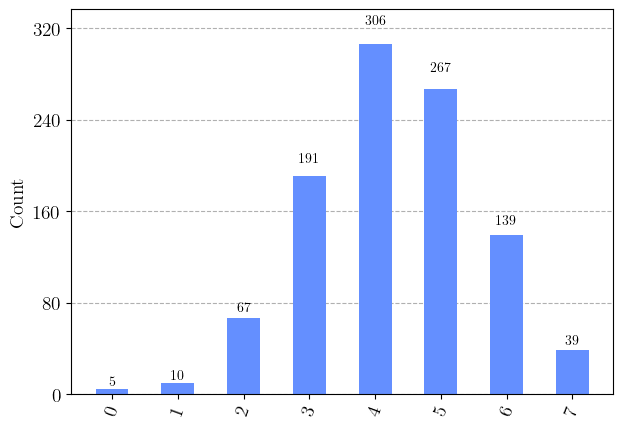

In [7]:
## Demonstration of amplitude damping circuit
# Define how many qumodes we want, and how many qubits we should use to represent each. Our basis will consist of Fock states |0> to |7>
num_qumodes = 1
num_qubits_per_qumode = 3 # The photon number which the Hilbert space truncates at is 2 ** num_qubits_per_qumode = 8

# Create circuit
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
cr = ClassicalRegister(num_qumodes * num_qubits_per_qumode)
circ = c2qa.CVCircuit(qmr, cr)

# To illustrate photon loss, first initialize the qumode in Fock state |7>
circ.cv_initialize(7, qmr[0])

# Now apply a delay gate and specify gate duration and units
gate_duration = 1
time_unit = "ms"
circ.cv_delay(duration=gate_duration, qumode=qmr[0], unit=time_unit)

# Now set a loss rate -- make it large enough such that we can actually see the loss
photon_loss_rate = 0.5 # This is a loss rate in units of 1/ms
noise_pass = c2qa.kraus.PhotonLossNoisePass(photon_loss_rates=photon_loss_rate, circuit=circ, time_unit=time_unit)

# To see the loss, we can make a measurement on the qumode and visualise counts with a histogram
circ.cv_measure(qmr[0], cr)

# Use noise pass with simulate
_, _, counts = c2qa.util.simulate(circ, noise_passes=noise_pass)

# Visualise photon loss using a histogram
visualization.plot_histogram(counts)

## Implementation of Photon Number Parity Operator

To detect an error, we measure the parity operator $\hat{P}$. This is achieved via the Hadamard test, a technique which relies on phase kickback using an ancillary qubit. In particular, we implement the following sequence of gates:
1. Apply Hadamard gate $[ H ]$ on the ancilla qubit to prepare the $\ket{+}$ state.
2. Apply a controlled phase space rotation gate $[ CR\left(\theta\right)=e^{i\theta\sigma_za^\dag a} ]$ of angle $\theta=\frac{\pi}{2}$ on both the ancilla qubit and qumode cavity, with the ancilla qubit as the control.
3. Apply an unconditional phase space rotation gate $[ R(\theta)\ =e^{i\theta a^\dag a}]$ of angle $\theta=-\frac{\pi}{2}$ to undo the global phase.
4. Apply a Hadamard gate on the ancilla qubit.
5. Measure the ancilla qubit in Z-basis. 

A qubit measurement of 0 or 1 then corresponds to a qumode parity of even or odd, respectively. 

![Parity operator circuit](https://github.com/C2QA/bosonic-qiskit/tree/main/tutorials/bosonic-kitten-code/figures/parity_operator_circ.svg)

The derivation for the circuit is given below:
\begin{align*}
\Psi_0 &= \ket{0}_{\text{qubit}} \otimes \ket{n}_{\text{qumode}} \\
\Psi_1 &= H \Psi_0 = \ket{+}_{\text{qubit}} \otimes \ket{n}_{\text{qumode}} \\
\Psi_2 &= CR(\frac{\pi}{2}) \Psi_1  \\
&= e^{i \frac{\pi}{2} \sigma_z \otimes \hat{n}} ( \hspace{2pt} \ket{+}_{\text{qubit}} \otimes \ket{n}_{\text{qumode}} \hspace{2pt} ) \\
&= \frac{1}{\sqrt{2}}(\hspace{2pt} \ket{0} \otimes e^{i \frac{\pi}{2} \hat{n}} \ket{n} + \ket{1} \otimes e^{-i \frac{\pi}{2} \hat{n}}\ket{n} \hspace{2pt}) \\
&= \frac{e^{i \frac{\pi}{2} \hat{n}}}{\sqrt{2}} (\hspace{2pt} \ket{0} \otimes \ket{n} + \ket{1} \otimes e^{-i \pi \hat{n}}\ket{n} \hspace{2pt}) \\
\Psi_3 &= R(-\frac{\pi}{2}) \Psi_2 \\
&= \frac{e^{-i \frac{\pi}{2} \hat{n}} e^{i \frac{\pi}{2} \hat{n}}}{\sqrt{2}} (\hspace{2pt} \ket{0} \otimes \ket{n} + \ket{1} \otimes e^{-i \pi \hat{n}}\ket{n} \hspace{2pt}) \\
&= \frac{1}{\sqrt{2}} (\hspace{2pt} \ket{0} \otimes \ket{n} + \ket{1} \otimes e^{-i \pi \hat{n}}\ket{n} \hspace{2pt})
\end{align*}
If $\ket{n}$ is odd:
\begin{align*}
\Psi_3 &= (\hspace{2pt} \ket{-} \otimes \ket{n} \hspace{2pt}) \\
\therefore \Psi_4 &= (\hspace{2pt} \ket{1} \otimes \ket{n} \hspace{2pt})
\end{align*}
and if $\ket{n}$ is even,
\begin{align*}
\Psi_3 &= (\hspace{2pt} \ket{+} \otimes \ket{n} \hspace{2pt}) \\
\therefore \Psi_4 &= (\hspace{2pt} \ket{0} \otimes \ket{n} \hspace{2pt})
\end{align*}

In [5]:
## Demonstration of photon parity measurement circuit
# Create new circuit with 1 qumode, 1 ancilla qubit, and 1 classical register for anc readout.
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
anc = AncillaRegister(1)
cr = ClassicalRegister(1)
circ = c2qa.CVCircuit(qmr, anc, cr)

circ.initialize([1, 0], anc[0]) # Initialize ancilla qubit in |0> state

# Initialize qumode in either odd parity or even parity Fock state
#circ.cv_initialize(2, qmr) # |2> Fock state
circ.cv_initialize(3, qmr) # |3> Fock state

# Apply hadamard on ancilla qubit
circ.h(anc[0])

# Apply controlled phase space rotation gate on qumode
circ.cv_c_r(pi/2, qmr[0], anc[0])

# Apply unconditional phase space rotation gate to correct global phase
circ.cv_r(-pi/2, qmr[0])

# Apply hadamard on ancilla qubit again, and measure the ancilla qubit.
circ.h(anc[0])
circ.cv_measure(anc, cr)

_, _, counts = c2qa.util.simulate(circ)

# Measurement will return 0 for even parity and 1 for odd parity
print(counts)

{'1': 1024}


## Error recovery operation

In the case where an error is detected, we must apply a correction which maps the system back onto the appropriate logical state. For the purposes of this tutorial, we will not go into detail on the specific sequence of gates needed to physically implement the error recovery operators for the binomial code. Instead, we will simply state the expected theoretical state transfer operation that maps the error states back onto our logical qubits.

If parity changes due to photon loss, the qumode will end up in one of two error states depending on the initial logical state: $\ket{1_L}\rightarrow\ket{1}\equiv\ket{E_1}$ or $\ket{0_L}\rightarrow\ket{3}\equiv\ket{E_0}$. To correct the error state back to the logical state, we therefore require some unitary operation ${\hat{U}}_{\text{odd}}$ that realizes the following mapping. 
\begin{align*}
\ket{E_0} = \ket{3} \rightarrow \ket{0_L} \\
\ket{E_1} = \ket{1} \rightarrow \ket{1_L}
\end{align*}

One choice for $\hat{U}_{\text{odd}}$ is the following, expressed in terms of a set of Fock state outer products:
$$
\hat{U}_{\text{odd}} = \ket{0_L} \bra{E_0} + \ket{1_L}\bra{E_1} + \left(\frac{\ket{0} - \ket{4}}{\sqrt{2}}\right) \bra{4} + \ket{1}\bra{0} + \ket{3}\bra{2}
$$
where the last three elements are present to ensure that the operator is unitary.

What if an error is not detected? One might think that it is most appropriate to do nothing in this case. However, this is not correct — quite non-intuitively, not detecting photon loss itself produces error! To see why, imagine someone gives you a qumode prepared either in Fock state $\ket{0}$ or $\ket{2}$ and you have the ability to detect single photon loss through parity measurements. Now imagine you measure the parity repeatedly over the course of a timescale much longer than expected rate of photon loss. If after many repeated measurements you have not detected any photon loss, then you might begin to suspect that the qumode is in the state $\ket{0}$, and each repeated measurement will only enhance this suspicion. In this way, even when the mode is in a superposition of $\ket{0}$ or $\ket{2}$, the state will decay toward $\ket{0}$ through this phenomenon known as “no-jump backaction”. Intuitively, this can be understood as the result of a Bayesian update on the state of the qumode, based on the new information that there was no jump.

Consequently, in the case of the binomial code, when we find that the parity has not changed, there will be a corresponding distortion experienced by $\ket{0_L}=(\ket{0}+\ket{4})/\sqrt{2}$ due to this effect, with the relative amplitude of $\ket{0} (\ket{4})$ slightly increasing (decreasing) when no photon loss is detected. This can be understood (to lowest order in the decay rate) as a small rotation between the logical state $\ket{0_L}$ and a third error state, $\ket{E_2}\equiv(\ket{0} - \ket{4})/\sqrt{2}$. In contrast, $\ket{1_L}$ will remain unaffected as it is a Fock state of definite photon number. To correct this error, we must apply a unitary operator $\hat{U}_{\text{even}}$ that produces the mapping,

\begin{align*}
\cos{\frac{\theta}{2}}\ket{0_L} + \sin{\frac{\theta}{2}} \ket{E_2} &\rightarrow \ket{0_L}, \hspace{20pt} \ket{E_2} = \frac{\ket{0} - \ket{4}}{\sqrt{2}} \\
\ket{1_L} &\rightarrow \ket{1_L}
\end{align*}

To first order, it can be shown that $\cos{\frac{\theta}{2}} \approx 1$ and $\sin{\frac{\theta}{2}} \approx \kappa t$, where $\kappa$ is a constant describing the rate of photon loss [1]. Therefore, we can express $\hat{U}_{\text{even}}$ as
\begin{align*}
\hat{U}_{\text{even}} &= \ket{0_L}\left[\frac{\hspace{2pt}(1 + \kappa t)\bra{0} + (1 - \kappa t)\bra{4}\hspace{2pt}}{\sqrt{2+2(kt)^2}}\right] + \ket{E_2} \left[\frac{\hspace{2pt}(1 - \kappa t)\bra{0} + (1 + \kappa t)\bra{4}\hspace{2pt}}{\sqrt{2+2(kt)^2}}\right] + \ket{1}\bra{1} + \ket{2}\bra{2} + \ket{3}\bra{3}\\
&= \left[\frac{\hspace{2pt} \ket{0}\bra{0} + \kappa t \ket{4}\bra{0} - \kappa t \ket{0}\bra{4} + \ket{4}\bra{4} \hspace{2pt}}{\sqrt{1+(kt)^2}}\right] + \ket{1}\bra{1} + \ket{2}\bra{2} + \ket{3}\bra{3}
\end{align*}
to be applied when we measure the parity to be even.

In an actual experiment, $\hat{U}_{\text{even}}$ and $\hat{U}_{\text{odd}}$ can be implemented as a non-trivial, numerically optimized series of pulses such that the overall effect applies the operators as written above. Here, we will avoid these technicalities and instead use the functionality of Bosonic Qiskit to build custom gates that implement $\hat{U}_{\text{even}}$ and $\hat{U}_{\text{odd}}$ into single gates that can be appended to our circuit.

## Implementing arbitrary gates in Bosonic Qiskit

To create the unitary matrix corresponding to our operators $\hat{U}_{\text{odd}}$ and $\hat{U}_{\text{even}}$, we can use the `fockmap()` helper function. Instead of creating a unitary matrix by manually filling out the individual elements within an array, the helper function allows you to populate a matrix by specifying the desired mapping between input and output Fock states. This is helpful for cases where the operator you want to specify is simply expressible in the Fock basis. Note that, at this time, `fockmap()` is intended for generating single qumodes gates only.

In [4]:
# Create empty matrix
empty = np.zeros((2**num_qubits_per_qumode, 2**num_qubits_per_qumode))

## Defining our theoretical operation for U_odd
# Map logical 1's photon loss state |1> back to logical 1. (i.e. |2><1|, where fock_input = <1|, and fock_output = |2>)
u_odd = c2qa.util.fockmap(matrix=empty, fock_input=[1], fock_output=[2]) 

# Map logical 0's photon loss state |3> to logical 0
u_odd = c2qa.util.fockmap(u_odd, fock_input=[3, 3], fock_output=[0, 4], amplitude=[1/np.sqrt(2), 1/np.sqrt(2)]) 

# Mappings to satisfy unitary condition
u_odd = c2qa.util.fockmap(u_odd, [5, 6, 7], [5, 6, 7])
u_odd = c2qa.util.fockmap(u_odd, [2, 0], [3, 1]) 
u_odd = c2qa.util.fockmap(u_odd, [4, 4], [0, 4], 1/np.sqrt(2) * np.array([1, -1]))

# Check that our matrix is indeed unitary
assert(is_unitary_matrix(u_odd))

## Defining our theoretical operation for U_even. 
# We will delay the building of the gate until we have the value we need for kt
def u_even(kt):
    # Map logical 1 back to logical 1
    u_even = c2qa.util.fockmap(empty, 2, 2) 

    # Map logical 0's error state to logical 0
    u_even = c2qa.util.fockmap(u_even, [0, 0, 4, 4], [0, 4, 0, 4], 1/np.sqrt(1 + kt**2) * np.array([1, kt, -kt, 1])) 

    # Mappings to satisfy unitary condition
    u_even = c2qa.util.fockmap(u_even, [1, 3, 5, 6, 7], [1, 3, 5, 6, 7]) 

    # Check that our matrix is indeed unitary
    assert(is_unitary_matrix(u_even))
    return u_even

Now that we have created the matrices corresponding to our operators, we can append the unitary matrices to the circuit as gates later on using the `cv_gate_from_matrix()` function — these gates will form the error recovery subcircuit. The `cv_gate_from_matrix()` function is similar in functionality to Qiskit's `circuit.unitary()` method, but adapted to Bosonic Qiskit’s `CVCircuit` class.

In [7]:
# Initialize new circuit 
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
cr = ClassicalRegister(num_qumodes * num_qubits_per_qumode)
circ = c2qa.CVCircuit(qmr, cr)

# Initialize qumode in |1_L> error state
circ.cv_initialize([0, 1], qmr)

# Append the u_odd matrix to circuit and measure
circ.cv_gate_from_matrix(u_odd, qmr[0])
circ.cv_measure(qmr[0], cr)

_, _, counts = c2qa.util.simulate(circ)

# We measure |2> Fock state, demonstrating recovery of the logical 1 state
print(counts)

{'2': 1024}


Note that because the operators that we defined in this tutorial ($\hat{U}_{\text{odd}}$, $\hat{U}_{\text{even}}$) are operators which would normally be implemented by multiple successive gates, Bosonic Qiskit functions such as `simulate(discretize=True)` with `PhotonLossNoisePass()` applied, or `animate_wigner()` may not be executed in a way that is accurate or physical. For better control over noise application within Bosonic Qiskit simulations, it is recommended to decompose your `cv_gate_from_matrix()` operators to a set of gates that can be physically realized.

## Implementing the full error correction circuit in Bosonic Qiskit

In [44]:
## Run this block to load in the functions we need for the simulation
# Runs circuit simulation
def error_correction_experiment(encoding: str, corrections: int, shots: int, additional_snapshots: int=10, total_circuit_time: int=1, apply_noise: bool=True, return_circuit: bool=False, had_damp: bool=False, identity: bool=False):
    multiplier = total_circuit_time
    total_circuit_time = int(total_circuit_time * 1000) # Code works with microsecond units, but input is in milliseconds
    
    if corrections > 333:
        raise ValueError("Please restrict number of correction procedures to 333 or less")
    photon_loss_rate = 0.0005

    num_qumodes = 1
    num_qubits_per_qumode = 3

    qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
    anc = AncillaRegister(1)
    cr = ClassicalRegister(1)
    circuit = c2qa.CVCircuit(qmr, anc, cr)

    ### 1. State Preparation
    perf_0 = np.array([1/np.sqrt(2), 0, 0, 0, 1/np.sqrt(2), 0, 0, 0])
    perf_1 = np.array([0, 0, 1, 0, 0, 0, 0, 0])
    
    if encoding == 'logi0':
        perf_state = perf_0
    elif encoding == 'logi1':
        perf_state = perf_1
    elif encoding == 'logi_xplus':
        perf_state = (perf_0 + perf_1)/np.sqrt(2)
    elif encoding == 'logi_xminus':
        perf_state = (perf_0 - perf_1)/np.sqrt(2)
    elif encoding == 'logi_yplus':
        perf_state = (perf_0 + 1j * perf_1)/np.sqrt(2)
    elif encoding == 'logi_yminus':
        perf_state = (perf_0 - 1j * perf_1)/np.sqrt(2)
    else:
        raise ValueError("Please input a valid state for the encoding")
    
    # Convert type to list
    perf_state = list(perf_state)
    #print(perf_state, "cv_initialzed this")
    
    # Initialize state
    circuit.cv_initialize(perf_state, qmr[0])

    ### 2. Using instructions stored in schedule, add snapshots, noise, and parity check + recovery operations
    schedule = _circuit_scheduler(corrections * multiplier, additional_snapshots * multiplier, total_circuit_time)
    schedule_copy = list(schedule.items())
    #print(schedule)

    adjustment = 0 # For calculating duration timing
    snapshot_counter = 0 # For tracking number of snapshots taken
    corr_position = [] # For tracking positions at which corrections were finished
    
    u_iden = c2qa.util.fockmap(empty, [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7])
    
    for index, (key, value) in enumerate(list(schedule.items())):
        # Instruction at 0µs should always be to take snapshot
        if (key == '0') & (value == 'snapshot'):
            circuit.save_statevector(label='snapshot_{}'.format(snapshot_counter), pershot=True)
            snapshot_counter += 1
            continue
        elif (key != '0'):
            pass
        else:
            raise Exception("Something seems to have gone wrong here")

        # Calculate delay gate durations using prevkey. Adjustment to duration timing is needed depending on previous instruction
        prevkey, prevvalue = schedule_copy[index - 1]
        delay_dur = int(key) - int(prevkey) + adjustment
        #print(delay_dur, key, value)
        adjustment = 0

        # Apply noise
        circuit.cv_delay(duration=delay_dur, qumode=qmr[0], unit="µs")

        # Apply snapshot only procedure
        if (value == 'snapshot'):
            # Don't take duplicate snapshots
            if (prevvalue == 'correction') & (int(key) == (int(prevkey) + 3)):
                pass
            else:
                circuit.save_statevector(label='snapshot_{}'.format(snapshot_counter), pershot=True)
                snapshot_counter += 1

        # Apply snapshot, parity check, recovery, snapshot 
        elif value == 'correction':
            # Find previous corr position, and determine kt_dur with that information
            while index > 0:
                k, v = list(schedule.items())[index-1]
                # Break loop if we iterated till start of dictionary
                if (v == 'snapshot') & (k == '0'):
                    kt_dur = int(key) - int(k)
                    break
                # Skip all snapshot instructions
                elif v == 'snapshot':
                    index -= 1
                # Find either snapshot+corr or corr instruction and extract kt_dur
                elif v != 'snapshot':
                    kt_dur = int(key) - int(k)
                    break
            #print(kt_dur)
            
            kt = photon_loss_rate * (kt_dur + 3)
            adjustment = -3

            # Parity check
            circuit.initialize([1, 0], anc[0])
            circuit.h(anc[0])
            circuit.cv_delay(duration=1, qumode=qmr[0], unit="µs")
            
            # Manually discretize gates by splitting 0.5µs pi/2 rotation into five 0.1µs pi/10 rotations
            for _ in range(5):
               circuit.cv_c_r(pi/10, qmr[0], anc[0], duration=0.1, unit="µs")
            for _ in range(5):
                circuit.cv_r(-pi/10, qmr[0], duration=0.1, unit="µs")
            # circuit.cv_c_r(pi/2, qmr[0], anc[0], duration=0.5, unit="µs")
            # circuit.cv_r(-pi/2, qmr[0], anc[0], duration=0.5, unit="µs")
            
            circuit.cv_delay(duration=1, qumode=qmr[0], unit="µs")
            circuit.h(anc[0])
            circuit.measure(anc[0], cr[0])

            # Apply recovery operation, without or with u_even
            if identity:
                
                with circuit.if_test((cr[0], 1), label='Recovery op') as else_:
                    circuit.cv_gate_from_matrix(u_odd, qmr[0], duration=0.1, unit="ns") #u_odd
                    circuit.reset(anc[0])
                with else_:
                    circuit.cv_gate_from_matrix(u_iden, qmr[0], duration=0.1, unit="ns") #u_iden
                
            else:
                with circuit.if_test((cr[0], 1), label='Recovery op') as else_:
                    circuit.cv_gate_from_matrix(u_odd, qmr[0], duration=0.1, unit="ns") #u_odd
                    circuit.reset(anc[0])
                with else_:
                    circuit.cv_gate_from_matrix(u_even(kt), qmr[0], duration=0.1, unit="ns") #u_even(kt)
            
            circuit.save_statevector(label='snapshot_{}'.format(snapshot_counter), pershot=True)
            snapshot_counter += 1
            corr_position.append(int(key) + 3)

        # Apply snapshot, parity check, recovery, followed by another snapshot
        else:
            circuit.save_statevector(label='snapshot_{}'.format(snapshot_counter), pershot=True)
            snapshot_counter += 1
            
            adjustment = -3
            # Find previous corr position, and determine kt_dur with that information
            while index > 0:
                k, v = list(schedule.items())[index-1]
                # Break loop if we iterated till start of dictionary
                if (v == 'snapshot') & (k == '0'):
                    kt_dur = int(key) - int(k)
                    break
                # Skip all snapshot instructions
                elif v == 'snapshot':
                    index -= 1
                # Find either snapshot+corr or corr instruction and extract kt_dur
                elif v != 'snapshot':
                    kt_dur = int(key) - int(k)
                    break
            #print(kt_dur)
            kt = photon_loss_rate * (kt_dur + 3)

            # Parity check
            circuit.initialize([1, 0], anc[0])
            circuit.h(anc[0])
            circuit.cv_delay(duration=1, qumode=qmr[0], unit="µs")
            
            # Manually discretize gates by splitting 0.5µs pi/2 rotation into five 0.1µs pi/10 rotations
            for _ in range(5): # Manually discretize cv_c_r gate by splitting one 1µs pi rotation into ten 0.1µs pi/10 rotations
               circuit.cv_c_r(pi/10, qmr[0], anc[0], duration=0.1, unit="µs")
            for _ in range(5):
                circuit.cv_r(-pi/10, qmr[0], duration=0.1, unit="µs")
            # circuit.cv_c_r(pi/2, qmr[0], anc[0], duration=0.5, unit="µs")
            # circuit.cv_r(-pi/2, qmr[0], anc[0], duration=0.5, unit="µs")
            
            circuit.cv_delay(duration=1, qumode=qmr[0], unit="µs")
            circuit.h(anc[0])
            circuit.measure(anc[0], cr[0])
            
            if identity:
                # Recovery operation
                with circuit.if_test((cr[0], 1), label='Recovery op') as else_:
                    circuit.cv_gate_from_matrix(u_odd, qmr[0], duration=0.1, unit="ns") #u_odd
                    circuit.reset(anc[0])
                with else_:
                    circuit.cv_gate_from_matrix(u_iden, qmr[0], duration=0.1, unit="ns") #u_even(kt)
                
            else:
                # Recovery operation
                with circuit.if_test((cr[0], 1), label='Recovery op') as else_:
                    circuit.cv_gate_from_matrix(u_odd, qmr[0], duration=0.1, unit="ns") #u_odd
                    circuit.reset(anc[0])
                with else_:
                    circuit.cv_gate_from_matrix(u_even(kt), qmr[0], duration=0.1, unit="ns") #u_even(kt)
                
            circuit.save_statevector(label='snapshot_{}'.format(snapshot_counter), pershot=True)
            snapshot_counter += 1
            corr_position.append(int(key) + 3)

    # Final delay gate
    finalkey, finalvalue = schedule_copy[-1]
    if finalvalue != 'snapshot':
        final_gate_delay = total_circuit_time - int(finalkey) - 3
    else:
        final_gate_delay = total_circuit_time - int(finalkey)
        
    circuit.cv_delay(duration=final_gate_delay, qumode=qmr[0], unit="µs")
    
    if return_circuit:
        return circuit
    
    ### 3. Define noise parameters
    # Noise pass for qumode photon loss
    noise_pass = c2qa.kraus.PhotonLossNoisePass(photon_loss_rates=photon_loss_rate, circuit=circuit, time_unit="µs")

    # Noise model for hadamard amplitude damping
    T1 = 10 # In µs
    hgate_duration = 1 # In µs
    error = amplitude_damping_error(1 - np.exp(-hgate_duration / T1))

    noise_model = NoiseModel()
    index, _ = circuit.find_bit(anc[0])
    noise_model.add_quantum_error(error, ['h'], [index])
    
    ### 4. Simulate circuit
    if apply_noise:
        if had_damp:
            state, result, _ = c2qa.util.simulate(circuit, shots=shots, per_shot_state_vector=True, return_fockcounts=False, noise_passes=noise_pass, noise_model=noise_model)
        else:
            state, result, _ = c2qa.util.simulate(circuit, shots=shots, per_shot_state_vector=True, return_fockcounts=False, noise_passes=noise_pass)
    elif not apply_noise:
        state, result, _ = c2qa.util.simulate(circuit, shots=shots, per_shot_state_vector=True, return_fockcounts=False)
    
    ### 5. Process data
    # Find fidelity and photon probability at each snapshot, across all shots
    traced_density_matrices = _state_traceout(circuit, state, result, snapshot_counter)
    expectation_list_tuple, fidelity_list, probability_list_tuple = _state_processor(encoding, perf_state, traced_density_matrices)
    
    # Find exact timing of each snapshot (we have to recalculate because no. of snapshots can change due to scheduling conflicts)
    snapshot_times = _snapshot_timings(schedule, total_circuit_time)
    
    return expectation_list_tuple, fidelity_list, probability_list_tuple, snapshot_times, corr_position#, circuit, schedule, snapshot_counter

# Trace out qubit for both sets of statevectors
def _state_traceout(circuit, state, result, actual_snapshots):
    # Process snapshot and final statevectors
    traced_snapshot_density_matrices = []
    for i in range(actual_snapshots):
        snapshot_list = result.data()['snapshot_{}'.format(i)]

        traced_snapshots = []
        for statevector in snapshot_list:
            traced_snapshots.append(c2qa.util.trace_out_qubits(circuit, statevector))

        traced_snapshot_density_matrices.append(traced_snapshots)

    traced_final_density_matrices = []
    for i in state:
        traced_final_density_matrices.append(c2qa.util.trace_out_qubits(circuit, i))
    
    traced_density_matrices = traced_snapshot_density_matrices + [traced_final_density_matrices]

    return traced_density_matrices

# Takes traced matrices and finds expectation, fidelity, and photon probability
def _state_processor(encoding, perf_state, traced_density_matrices):
    #print(perf_state, "compute fidelity with this")
    
    perf_0 = [1/np.sqrt(2), 0, 0, 0, 1/np.sqrt(2), 0, 0, 0]
    perf_1 = [0, 0, 1, 0, 0, 0, 0, 0]
    err = [1/np.sqrt(2), 0, 0, 0, -1/np.sqrt(2), 0, 0, 0]
    
    # Bring into qubit space
    projector = Operator(np.outer([1, 0], perf_0) + np.outer([0, 1], perf_1))
    
    # Z expectation
    if (encoding == 'logi0') or (encoding == 'logi1'):
        pauli = np.array([[1, 0], [0, -1]])
        
    # X expectation
    elif (encoding == 'logi_xplus') or (encoding == 'logi_xminus'):
        #projector = Operator(np.outer([1/np.sqrt(2), 1/np.sqrt(2)], (perf_0 + perf_1)/np.sqrt(2)) + np.outer([1/np.sqrt(2), -1/np.sqrt(2)], (perf_0 - perf_1)/np.sqrt(2)))
        pauli = np.array([[0, 1], [1, 0]]) 
    
    # Y expectation
    elif (encoding == 'logi_yplus') or (encoding == 'logi_yminus'):
        #projector = Operator(np.outer([1/np.sqrt(2), 1j/np.sqrt(2)], (perf_0 + 1j * perf_1)/np.sqrt(2)) + np.outer([1/np.sqrt(2), 1j/np.sqrt(2)], (perf_0 - 1j * perf_1)/np.sqrt(2)))
        pauli = np.array([[0, -1j], [1j, 0]])

    # Compute from each density matrix 1) Pauli expectation, 2) fidelity, 3) probability of measuring photon number
    expectation_list, exp_prob_list, fidelity_list, probability_listA, probability_listB = [], [], [], [], []
    for density_matrix_list in traced_density_matrices:
        
        cycle_list_expectation, cycle_list_exp_prob, cycle_list_fid, cycle_list_probA, cycle_list_probB = [], [], [], [], []
        for matrix in density_matrix_list:
            #print(matrix.trace())
            # Pauli Expectation
            qubit_space_projected_state = matrix.evolve(projector)
            projection_prob = qubit_space_projected_state.trace()
            
            expectation = (qubit_space_projected_state/projection_prob).expectation_value(pauli)
            
            cycle_list_exp_prob.append(projection_prob)
            cycle_list_expectation.append(expectation)
            
            # Fid
            cycle_list_fid.append(round(state_fidelity(matrix, Statevector(perf_state)), 6))
            
            # Photon meas prob
            cycle_list_probA.append(list(matrix.probabilities(decimals=5))) # Photon number
            
            fid0 = round(state_fidelity(matrix, perf_0), 6)
            fiderr = round(state_fidelity(matrix, err), 6)
            cycle_list_probB.append([fid0, fiderr]) # w/ respect to specific states
            
            # Avg photon num
            #cycle_list_avg_photon.append(c2qa.util.avg_photon_num(matrix))

        expectation_list.append(cycle_list_expectation)
        exp_prob_list.append(cycle_list_exp_prob)
        fidelity_list.append(cycle_list_fid)
        probability_listA.append(cycle_list_probA)
        probability_listB.append(cycle_list_probB)
        #avg_photon_list.append(cycle_list_avg_photon)

    return (expectation_list, exp_prob_list), fidelity_list, (probability_listA, probability_listB)

# Function used to determine order and timing in which snapshots and corrections are done.
def _circuit_scheduler(corrections, snapshots, total_time=1000):
    # Schedule snapshots
    if snapshots == 0:
        pass
    else:
        snapshot_schedule = {"{}".format(round(i * (total_time/snapshots))): 'snapshot' for i in range(snapshots)}

    # Schedule corrections
    corr_interval = total_time/(1 + corrections)
    correction_schedule = {"{}".format(int((i + 1) * corr_interval)): 'correction' for i in range(corrections)}
    
    
    # If no corrections, return snapshot_schedule
    if corrections == 0:
        return snapshot_schedule
    # If no snapshots, return correction_schedule with 1 snapshot at start
    elif snapshots == 0:
        correction_schedule = {**{'0' : 'snapshot'}, **correction_schedule}
        return correction_schedule
    else:
        pass
        
    # Merge the two dicts from above. If duplicate keys exist then concatenate values together.
    try:
        unsorted_merged_schedule = {**snapshot_schedule, **correction_schedule}

        for key, value in list(snapshot_schedule.items()):
            if key in list(correction_schedule.keys()):
                unsorted_merged_schedule[key] = '{}'.format(value + '+' + correction_schedule[key])
            else:
                pass
    except:
        print("_circuit_scheduler() has an error")
    
    # Sort merged dicts
    merged_schedule = {key:value for key, value in sorted(unsorted_merged_schedule.items(), key=lambda item: int(item[0]))}

    # Ensure that all corrections happen at least 3µs before each snapshot
    # but if two successive corrections happen within 3µs of each other, drop the second correction
    DictItems = list(merged_schedule.items())
    unsorted_cleaned_schedule = dict(merged_schedule)
    for index, (key, value) in enumerate(DictItems):
        # index == 0 case
        if index == 0:
            nextkey, _ = DictItems[index + 1]
            if (value == 'correction') & (int(key) + 3 > int(nextkey)):
                unsorted_cleaned_schedule['{}'.format(str(int(nextkey) - 3))] = unsorted_cleaned_schedule.pop('{}'.format(key))
        # index != 0 case
        else:
            # Automatically break loop when we get to last element of dictionary
            try:
                nextkey, _ = DictItems[index + 1]
                prevkey, _ = DictItems[index - 1]
            except:
                break
            
            if (value == 'correction') & (int(key) + 3 > int(nextkey)) & (int(prevkey) < int(key) - 3):
                unsorted_cleaned_schedule['{}'.format(str(int(nextkey) - 3))] = unsorted_cleaned_schedule.pop('{}'.format(key))
            elif (value == 'correction') & (int(key) + 3 > int(nextkey)):
                unsorted_cleaned_schedule.pop('{}'.format(key))
                print("Due to scheduling conflicts, a correction scheduled at {}µs will be dropped".format(key))

    # Sort overall_schedule
    cleaned_schedule = {key:value for key, value in sorted(unsorted_cleaned_schedule.items(), key=lambda item: int(item[0]))}

    return cleaned_schedule

# Function for extracting snapshot timings (in ms)
def _snapshot_timings(schedule, total_circuit_time):
    timings = []
    sch_copy = list(schedule.items())
    prevkey, prevvalue = 0, 0 # Just so that first iteration doesn't throw an error
    
    for index, (key, value) in enumerate(list(schedule.items())):
        if index != 0:
            prevkey, prevvalue = sch_copy[index - 1]
        
        if value == 'snapshot':
            if (prevvalue == 'correction') & (int(key) == (int(prevkey) + 3)):
                pass
            else:
                timings.append(int(key)/1000)
            
        elif value =='correction':
            timings.append((int(key) + 3)/1000)
        else:
            timings.append(int(key)/1000)
            timings.append((int(key) + 3)/1000)
            
    timings.append(total_circuit_time/1000)
    
    return timings

# Function for extracting positions where corrections were done
def correction_positions(corr_positions, correction_avg_fidelity, correction_snapshot_timings):
    corr_time = [key/1000 for key in corr_positions]
    corr_fid = [correction_avg_fidelity[correction_snapshot_timings.index(timing)] for timing in corr_time]
    
    return corr_time, corr_fid

# Function for fitting exponential curve
def curve_fitter(x, y, sign=1):
    popt, pcov = curve_fit(lambda x, b: sign * np.exp(-x/b), x, y)
    sigma = np.sqrt(np.diag(pcov))
    
    lifetime = round(popt[0], 2)
    uncertainty = round(sigma[0], 3)
    
    return lifetime, uncertainty

Now that we have introduced the individual ingredients, we can proceed with assembling the complete error correction circuit. The basic structure of the circuit that we will simulate is as follows:

a. ![Full EC circuit without corrections](https://github.com/C2QA/bosonic-qiskit/tree/main/tutorials/bosonic-kitten-code/figures/full_ec_circ_nocorr.svg) \
b. ![Full EC circuit with corrections](https://github.com/C2QA/bosonic-qiskit/tree/main/tutorials/bosonic-kitten-code/figuresfull_ec_circ_corr.svg)
*a) is a diagram of the no correction circuit, while b) is a diagram of the correction circuit. The red dashed line in both diagrams represents a “snapshot”. The grey dashed box indicates the repeated gates in the simulation. The delay gate in b. includes the argument $T$ to allow for a variable duration chosen according to the number of corrections executed every 1 ms. The parity check gate has a grey fill to indicate that it includes the effects of photon loss.*

First, the logical state is initialized. Second, amplitude damping noise is initialized. Third, the error correction circuit is applied. The error correction circuit first detects whether or not an error has occurred, and follows this by executing the appropriate recovery operation. The error model and error correction circuit can be repeated any number of times to simulate a physical experiment with multiple corrections applied onto the logical state. We note that, for simplicity, we assume the ancillary qubit to be error-free — while not investigated here, this assumption can be relaxed by including additional noise passes that simulate qubit errors. 

Other assumptions include:
1.	All gates execute with no coherent errors. 
2.	State preparation and readout error is also error-free.
3.	The photon loss rate is chosen such that the logical qubit has a lifetime of ~1 ms without error-correction.
4.	Parity measurement will take 3 µs in total to execute, while recovery/correction operation is instantaneous. Photon loss may occur during the parity measurement.

We simulate the evolution of an initialized quantum state under periodic application of the error correction subcircuit and take “snapshots” after every detection and recovery operation so that we can track the single-shot trajectories of the state over the duration of the simulation. The full circuit is shown in the figures above.

Here, we elect to simulate a qumode initialized in the following two logical states — $\ket{0_L}$ and $\ket{1_L}$. To recap, the states are defined as follows:

\begin{align*}
\ket{0_L} &= \frac{1}{\sqrt{2}} [\ket{0} + \ket{4}] \\
\ket{1_L} &= \ket{2}
\end{align*}

To evaluate the effectiveness of the error correction circuit, we simulate a circuit that alternates between delay gates (which effectively apply the amplitude damping error), and error correction circuits (which attempt to recover the original state in the case that an error has occurred). The error correction circuit is only applied once per ms, while delay gates “fill” the rest of the time. The total duration of the simulated circuit is 12ms.

Since the circuit is dynamically generated based on the values of the parameters below, the layout of the circuit for a specific set of parameters can be accessed by uncommenting the last few lines of the cell below. From the simulation results, we will consider a) the state fidelity, and b) the probability of measuring a particular Fock state. 

In [60]:
### Adjust these parameters ###
num_corr = 1 # per ms, number of correction circuits applied
additional_snaps = 2 # per ms, number of additional snapshots taken in between each correction circuit

noise_only_circ_time = 12 # ms, total duration of noise-only circuit
correction_circ_time = 12 # ms, total duration of correction circuit

shots = 1000 # Number of times circuit is repeated
encoding=['logi0', 'logi1', 'logi_xplus', 'logi_xminus'] # Input 'logi0', 'logi1', 'logi_xplus', 'logi_xminus', 'logi_yplus', or 'logi_yminus'
## 

### If you wish to generate the circuit diagram for a particular simulation, uncomment these lines. ###
# noise_circuit = error_correction_experiment(encoding[0], 0, shots, 10, noise_only_circ_time, return_circuit=True)
# correction_circuit = error_correction_experiment(encoding[0], num_corr, shots, additional_snaps, correction_circ_time, return_circuit=True)

# noise_circuit.draw()
# correction_circuit.draw()

### Simulation 1

To simplify analysis, here we will specialize our first simulation to apply $\hat{U}_{\text{odd}}$ only during the error correction state, which will successfully correct single photon loss events, but will not correct the dephasing of $\ket{0_L}$ due to no-jump backaction. Thus, if the state is measured to have even parity, the recovery subcircuit will do nothing. The effect of applying both $\hat{U}_{\text{odd}}$ and $\hat{U}_{\text{even}}$ will be discussed in the second simulation.

For the first simulation, we will initialize the qumode with four different logical Pauli states — $\ket{0_L}, \ket{1_L}, \ket{+_L}$ and $\ket{-_L}$.

Logical Z Pauli states: 
\begin{align*}
\ket{0_L} &= \frac{1}{\sqrt{2}} [\ket{0} + \ket{4}] \\
\ket{1_L} &= \ket{2}
\end{align*}

Logical X Pauli states:
\begin{align*}
\ket{+_L} &= \frac{1}{\sqrt{2}} [\ket{0_L} + \ket{1_L}] \\
\ket{-_L} &= \frac{1}{\sqrt{2}} [\ket{0_L} - \ket{1_L}] 
\end{align*}

In [61]:
# Run simulation with and without correction. Disable u_even
noise_only_simulation_list = []
correction_simulation_list = []

for i in encoding:
    noise_only_simulation_list.append(error_correction_experiment(i, 0, shots, additional_snaps, noise_only_circ_time))
    correction_simulation_list.append(error_correction_experiment(i, num_corr, shots, additional_snaps, correction_circ_time, identity=True))

a) State Fidelity

State fidelity is calculated as the square of the overlap between the initial state $\ket{\psi_{\text{initial}}}$ and the time evolved state $\ket{\psi(t)}$.
\begin{align*}
F(\ket{\psi_{\text{initial}}}, \ket{\psi(t)}) = |\braket{\psi_{\text{initial}} | \psi(t)}|^2
\end{align*}

If the circuit starts with the $\ket{1_L} = \ket{2}$, the final state at the end of each shot of the simulation will either be 1) Fock state $\ket{2}$, hence resulting in $F = |\braket{2|2}|^2 = 1$, or 2) any other Fock state, hence producing $F = |\braket{n|2}|^2 = 0$, where $n \neq 2$ (Fock states are mutually orthogonal). The average fidelity across all possible shots thus describes the ratio between shots that end with a perfectly preserved state, and shots that end without preserving the state.

In density matrix notation ($\rho \equiv \ket{\psi} \bra{\psi} $), the fidelity is given by the following.
\begin{align*}
F(\rho_{initial}, \rho_{final}) = Tr(|\sqrt{\sqrt{\rho_{i}} \rho_{f} \sqrt{\rho_{i}}}|)^2
\end{align*}

To visualize the evolution of state fidelity as a function of circuit time, the trajectory of the state fidelity is plotted using Matplotlib. As we expect the fidelity to decay exponentially, the data will be fitted with $f(t) = e^{-t/\tau}$, where $\tau$ is a constant representing the lifetime of the logical qubit. Red boxes are used to mark out the snapshots taken immediately after applying the recovery procedure.

For brevity, we will only include the results from setting $\ket{1_L}$ as the initial state.

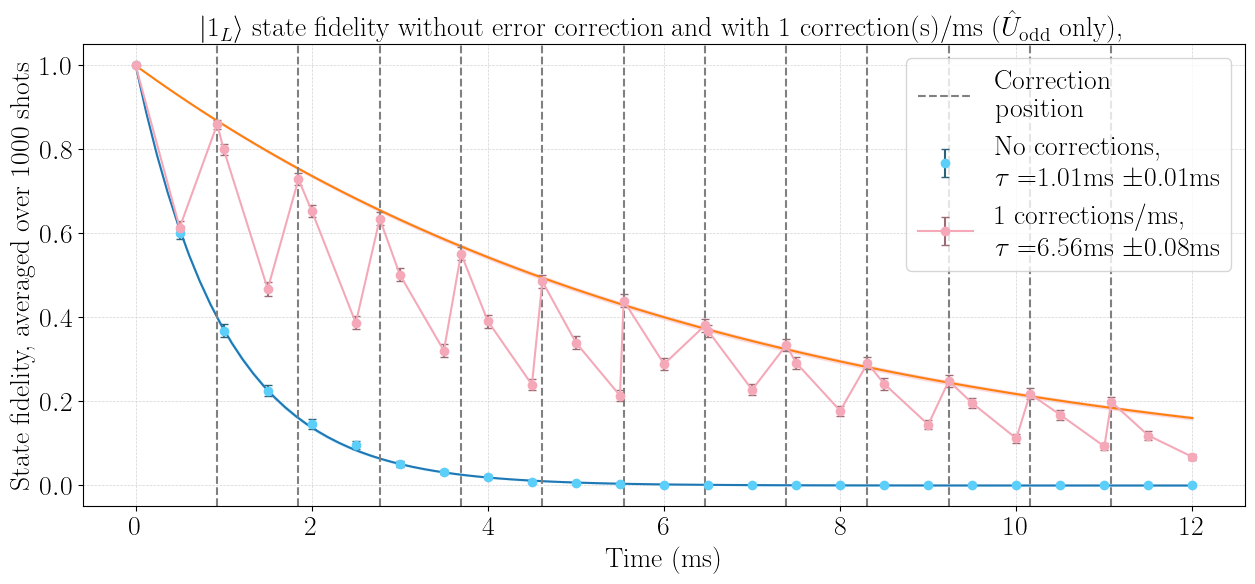

In [64]:
## Fidelity visualisation
index = encoding.index('logi1')
value = 'logi1'

_, noise_only_fid, _, noise_only_snapshot_timings, _ = noise_only_simulation_list[index]
_, correction_fid, _, correction_snapshot_timings, corr_position_times = correction_simulation_list[index]

noise_only_avg_fid = [round(np.average(cycle), 4) for cycle in noise_only_fid]
noise_only_avg_fid_error = [round(np.std(cycle)/np.sqrt(shots), 4) for cycle in noise_only_fid]

correction_avg_fid = [round(np.average(cycle), 4) for cycle in correction_fid]
correction_avg_fid_error = [round(np.std(cycle)/np.sqrt(shots), 4) for cycle in correction_fid]

# Find correction positions
x, y = correction_positions(corr_position_times, correction_avg_fid, correction_snapshot_timings)

# Fit fidelity data using an exponential decay function
noise_only_lifetime, noise_lifetime_uncertainty = curve_fitter(noise_only_snapshot_timings, noise_only_avg_fid)
correction_lifetime_perf, correction_lifetime_uncertainty = curve_fitter(x, y)

# Round values to 2 decimal places
noise_lifetime_uncertainty = round(noise_lifetime_uncertainty, 2)
correction_lifetime_uncertainty = round (correction_lifetime_uncertainty, 2)

# Plot fidelity data w/ uncertainty
plt.figure(figsize=(15,6))

plt.errorbar(noise_only_snapshot_timings, noise_only_avg_fid, yerr=noise_only_avg_fid_error,
        label=r'No corrections, ' + '\n' + r'$\tau = $' + str(noise_only_lifetime) + r'ms $\pm$' + str(noise_lifetime_uncertainty) + r'ms', 
        marker='o', color='#5BCEFA', capsize=3, ecolor='#2a6278', linestyle='None')
plt.errorbar(correction_snapshot_timings, correction_avg_fid, yerr=correction_avg_fid_error,
        label=str(num_corr) + r' corrections/ms,' + '\n' + r'$\tau = $' + str(correction_lifetime_perf) + r'ms $\pm$' + str(correction_lifetime_uncertainty) + r'ms', 
        marker='o', color='#F5A9B8', capsize=3, ecolor='#9c6b75')

# Plot curve fits w/ uncertainty
noise_curve_timing = np.linspace(0, noise_only_circ_time, 100)
plt.plot(noise_curve_timing, np.exp(-noise_curve_timing/noise_only_lifetime))
plt.fill_between(noise_curve_timing, np.exp(-noise_curve_timing/(noise_only_lifetime + noise_lifetime_uncertainty)), 
                np.exp(-noise_curve_timing/(noise_only_lifetime - noise_lifetime_uncertainty)), color='#5BCEFA', alpha=0.3)

corr_curve_timing = np.linspace(0, correction_circ_time, 100)
plt.plot(corr_curve_timing, np.exp(-corr_curve_timing/correction_lifetime_perf))
plt.fill_between(corr_curve_timing, np.exp(-corr_curve_timing/(correction_lifetime_perf + correction_lifetime_uncertainty)), 
                np.exp(-corr_curve_timing/(correction_lifetime_perf - correction_lifetime_uncertainty)), color='#F5A9B8', alpha=0.3)

# Plot correction positions
label = 'Correction \n position'
for i in x:
        plt.axvline(x=i, color='grey', label=label, linestyle="--")
        label = ''

plt.xlabel("Time (ms)", size=20)
plt.ylabel("State fidelity, averaged over {} shots".format(shots), size=20)
plt.title(r'$\lvert$' + str(encoding_format.get(value)) + r'$\rangle$' + ' state fidelity without error correction and with ' + str(num_corr) + r' correction(s)/ms ($\hat{U}_{\text{odd}}$ only),', size=20)
plt.grid(color = 'lightgrey', linestyle = 'dashed', linewidth = 0.5)
plt.legend(loc='upper right', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

On average, the error correction circuit can extend the lifetime of the state for longer than if no corrections were done at all. As this simulation does not include any other errors, it possible for us to extend the state indefinitely by increasing the number of correction circuits that are applied every ms.

If we repeated simulation 1 with a varying number of corrections per ms, the general trend we observe is that the lifetime of the logical state will increase. The state fidelity trajectory and its corresponding curve fit are plotted for each repeat.

For brevity, we will only include the results from setting $\ket{1_L}$ as the initial state.

KeyboardInterrupt: 

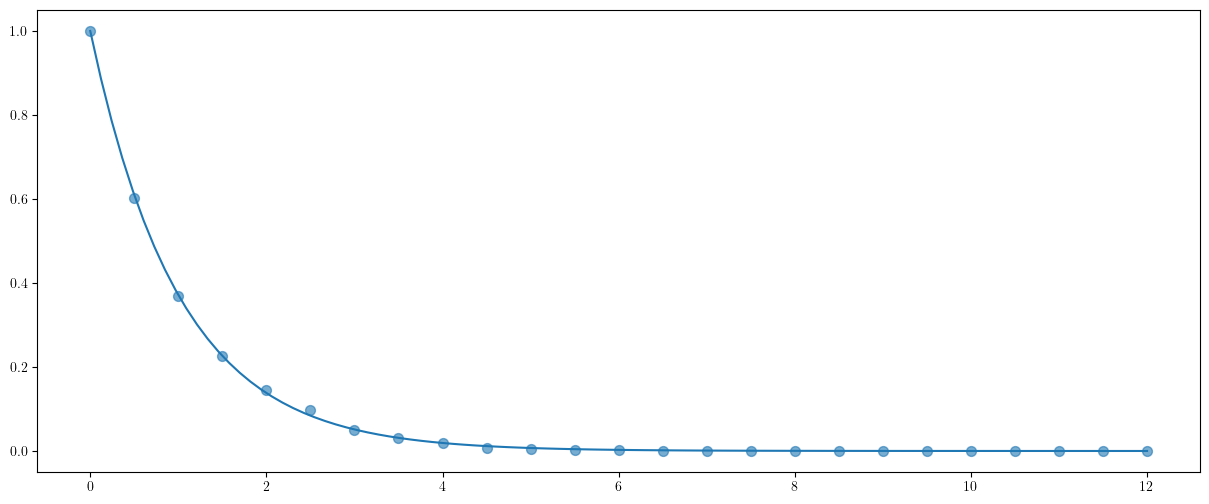

In [97]:
# Compute exponential fit across a variety of corrections/ms
_num_corr = [1, 2, 5, 10]
_correction_circ_time = [12 for _ in _num_corr] #[(i + 1) * 8 for i in range(5)]
_additional_snaps = 0
_shots = 1000
_encoding='logi1'

# Colors for plotting
colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Plot noise_only trial as simulated previously
plt.figure(figsize=(15,6))
plt.scatter(noise_only_snapshot_timings, noise_only_avg_fid, marker='o', color='#1f77b4', zorder=3, alpha=0.6, linestyle='None', s= 50)
plt.plot(noise_curve_timing, np.exp(-noise_curve_timing/noise_only_lifetime), label=r'0 corrections, ' + '\n' + r'$\tau$ = ' + str(noise_only_lifetime) + r'ms $\pm$' + str(noise_lifetime_uncertainty) + r'ms', color='#1f77b4')

# Plot all other correction trials w/ lifetimes
for index, _corrections in enumerate(_num_corr):
    # print(corrections, "Run starting") # Debug
    _, _correction_fid, _, _correction_snapshot_timings, _corr_position_times = error_correction_experiment(_encoding, _corrections, _shots, _additional_snaps, _correction_circ_time[index], identity=True)
    _correction_avg_fid = [round(np.average(cycle), 4) for cycle in _correction_fid]
    
    _x, _y = correction_positions(_corr_position_times, _correction_avg_fid, _correction_snapshot_timings)
    _lifetime, _lifetime_uncertainty = curve_fitter(_x, _y)
    
    _curve_timing = np.linspace(0, _correction_circ_time[index], 100)
    if _additional_snaps != 0:
        plt.plot(correction_snapshot_timings, correction_avg_fid, marker='o', color=colors[index + 1], alpha=0.2)
    plt.plot(_curve_timing, np.exp(- _curve_timing/_lifetime), 
             label=str(_num_corr[index]) + r' corrections/ms, ' + '\n' + r'$\tau = $' + str(_lifetime) + r'ms $\pm$' + str(_lifetime_uncertainty) + r'ms', color=colors[index + 1])
    
    plt.scatter(_x, _y, marker='s', color=colors[index + 1], zorder=3, alpha=0.6, linestyle='None', s= 50)

plt.xlabel("Time (ms)", size=20)
plt.ylabel("State fidelity, averaged over {} shots".format(shots), size=20)
plt.title(r'$\lvert$' + str(encoding_format.get(value)) + r'$\rangle$' + r' state fidelity for varying circuit parameters ($\hat{U}_{\text{odd}}$ only)', size=20)
plt.grid(color = 'lightgrey', linestyle = 'dashed', linewidth = 0.5)
plt.legend(fontsize=20, bbox_to_anchor=(1.32, 0.5), loc='right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

b) Photon probability

Photon probability for any state is calculated as the square of the overlap between that state $\ket{\psi}$ and the the time evolved state $\ket{\psi(t)}$.

\begin{align*}
P(\ket{\psi}) = |\braket{\psi| \psi(t)}|^2, \hspace{20pt} \ket{\psi}=\ket{0}, \ket{1}, \ket{2}, ... , \frac{\ket{0}+\ket{4}}{\sqrt{2}}, ...
\end{align*}

The probability of measuring a particular Fock state will change over the course of the circuit. Over time, Fock states with higher photon number will decay into a lower photon number state. As the error correction circuit seeks to increase the lifetime of the logical state, we can visualize the action of the recovery procedure by plotting the photon probability trajectory as it evolves over the course of the circuit.

For clarity, we will extract out the results of a single shot from the existing simulation. The trajectories for the 'no correction' and 'correction' runs are plotted on separate graphs. The specific locations at which corrections were done are marked by grey dashed lines. 

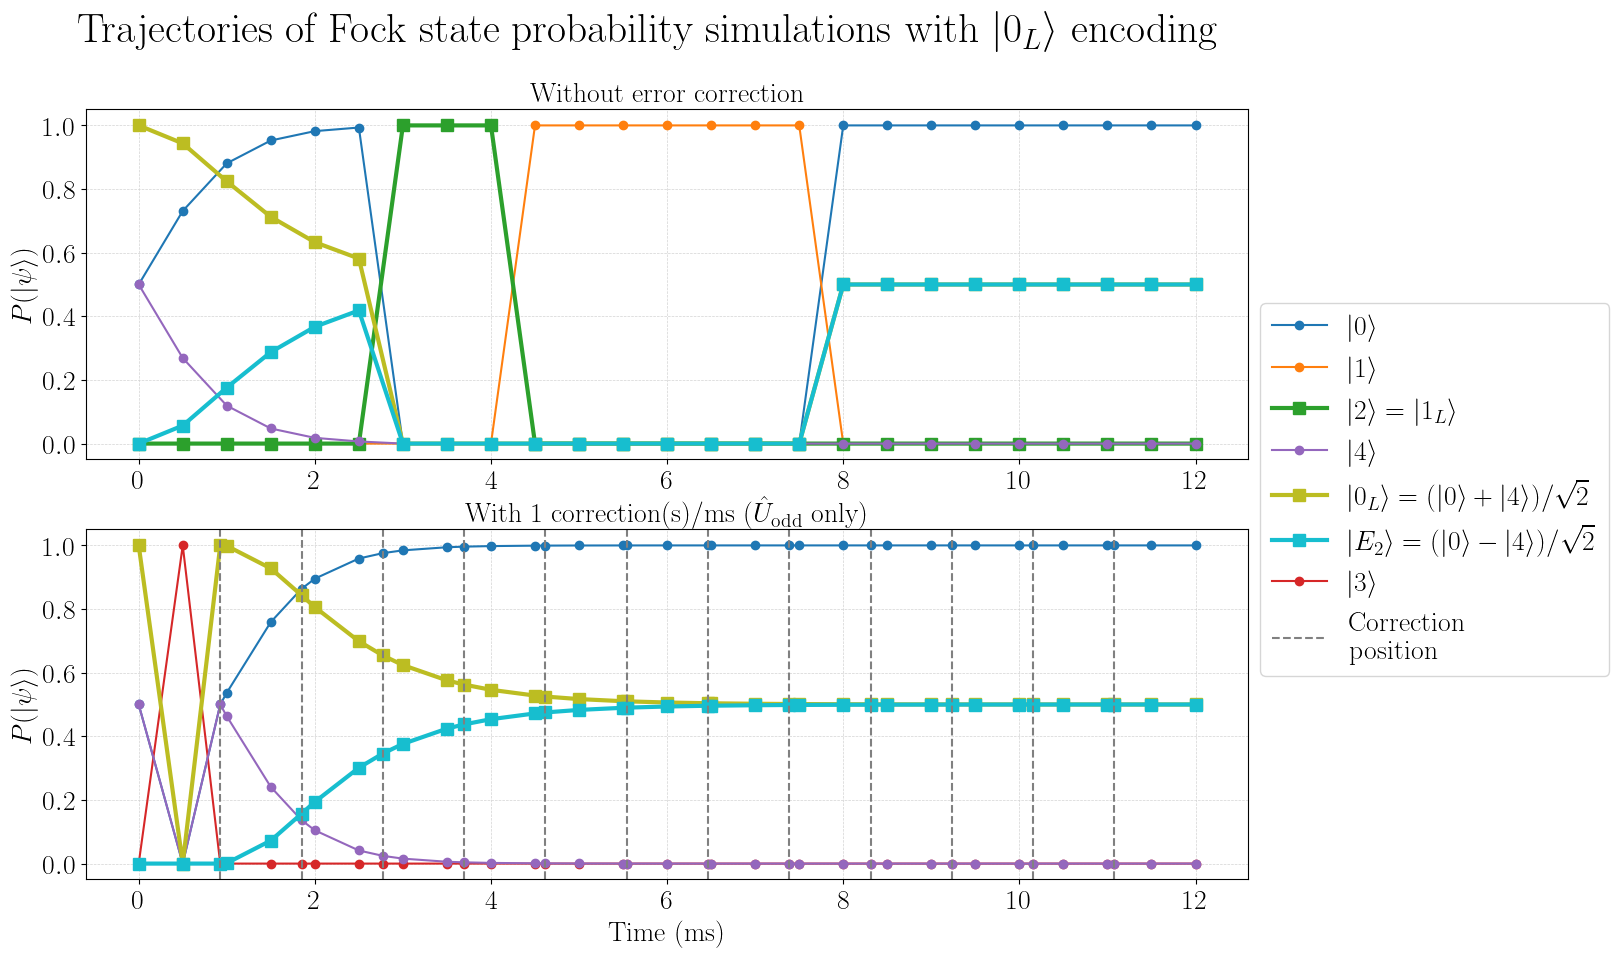

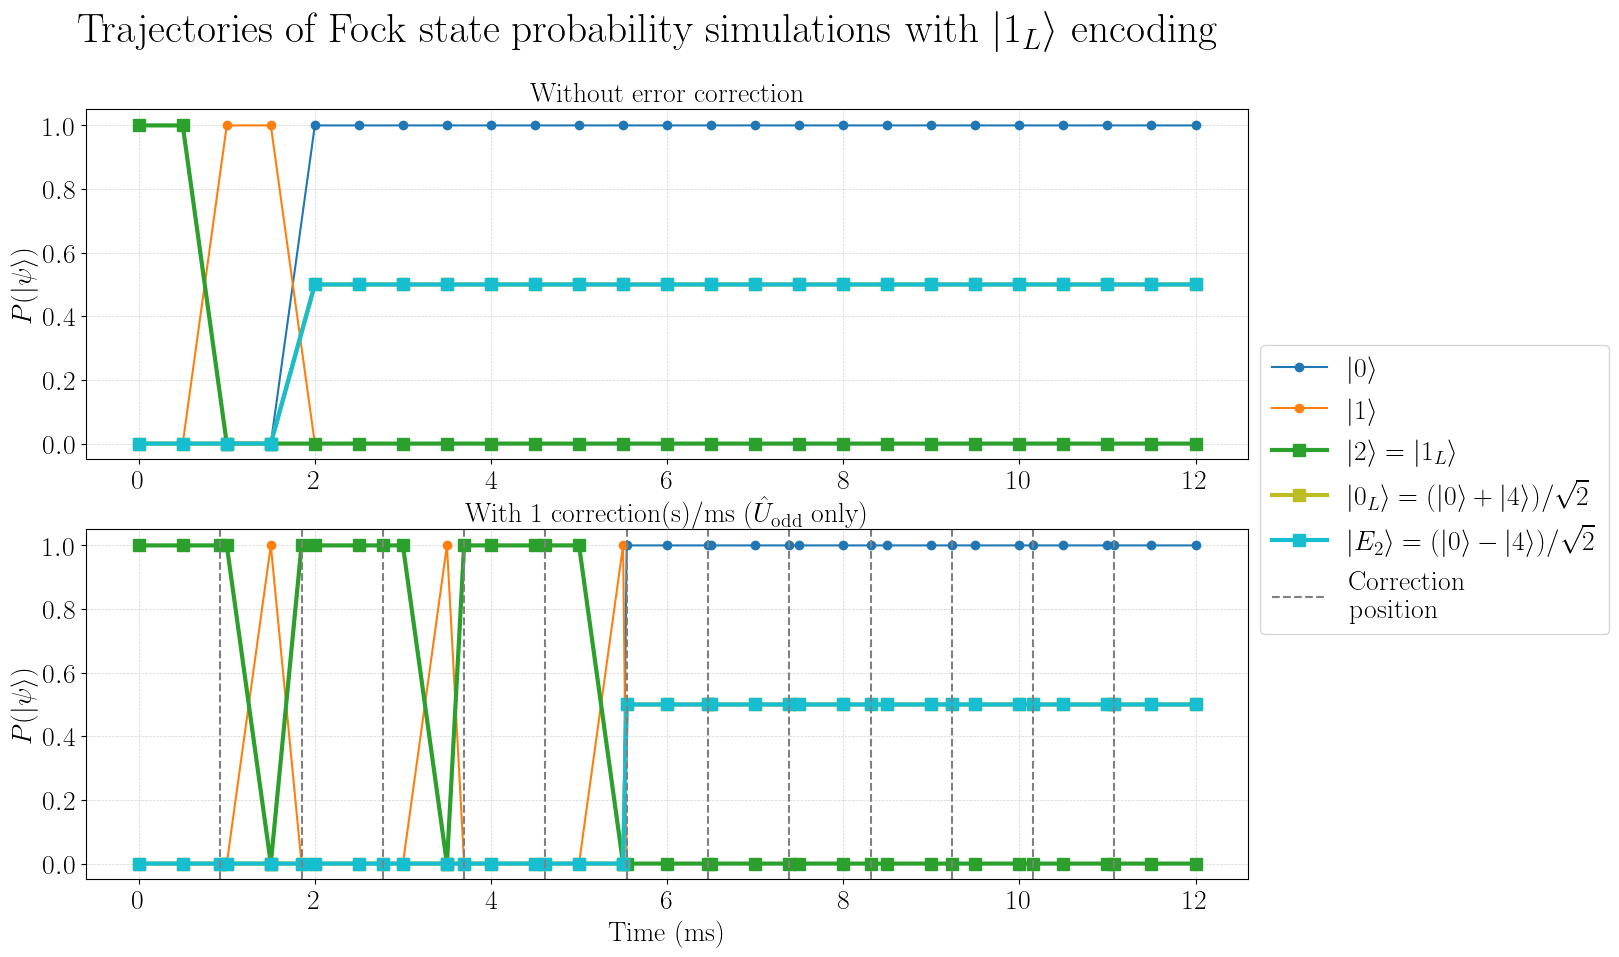

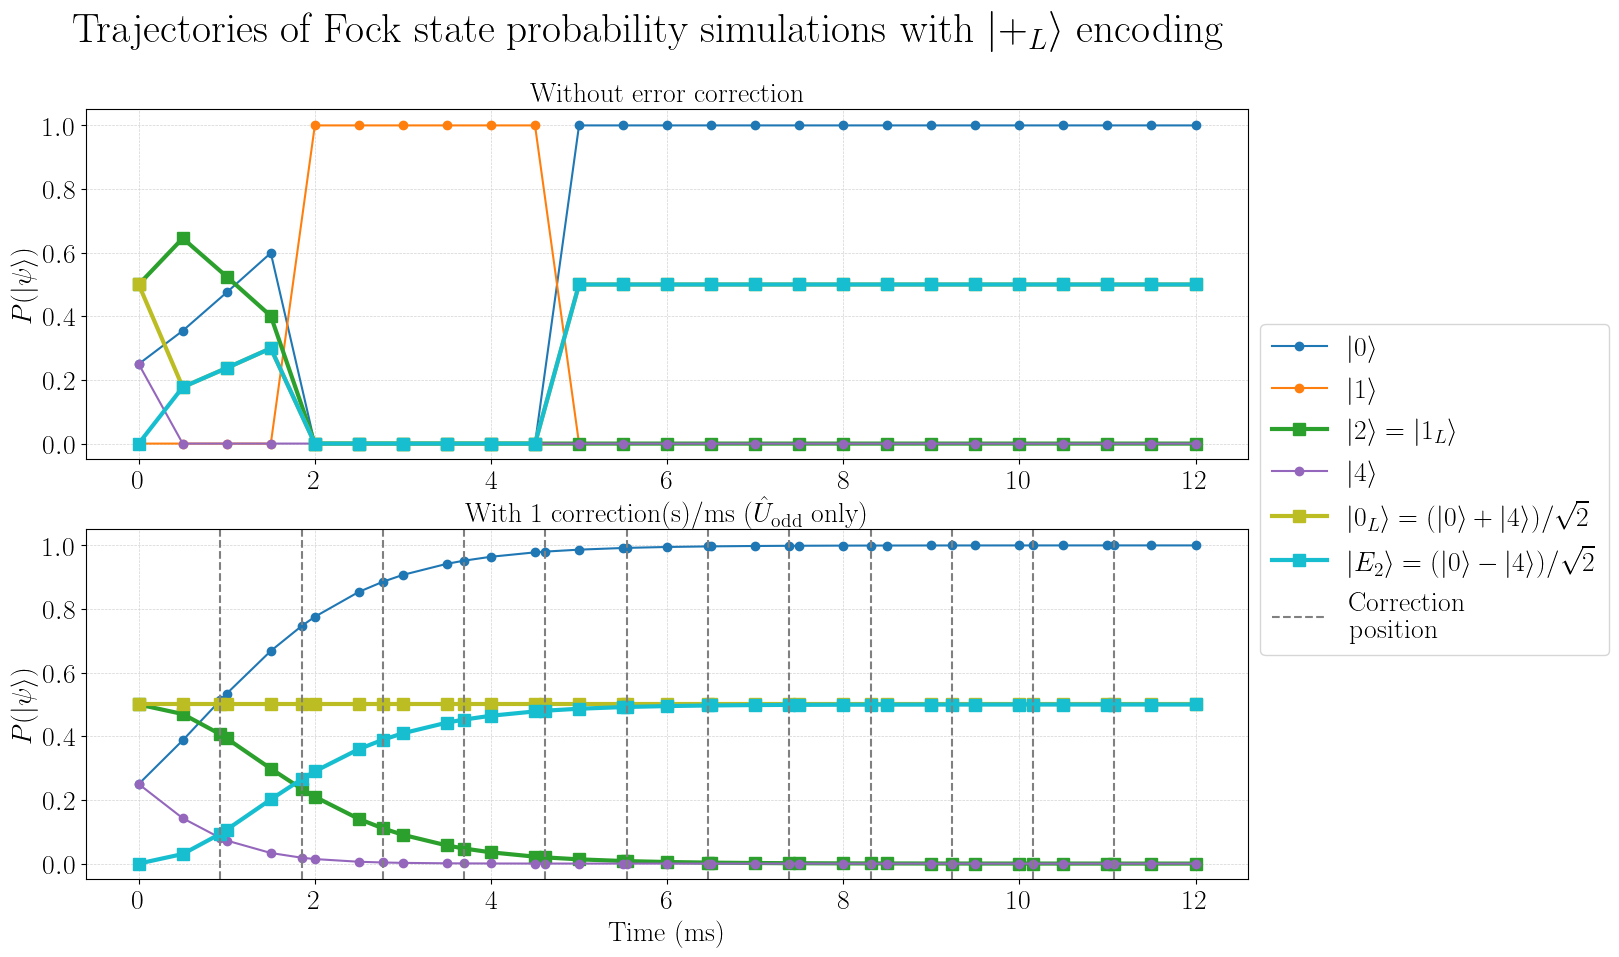

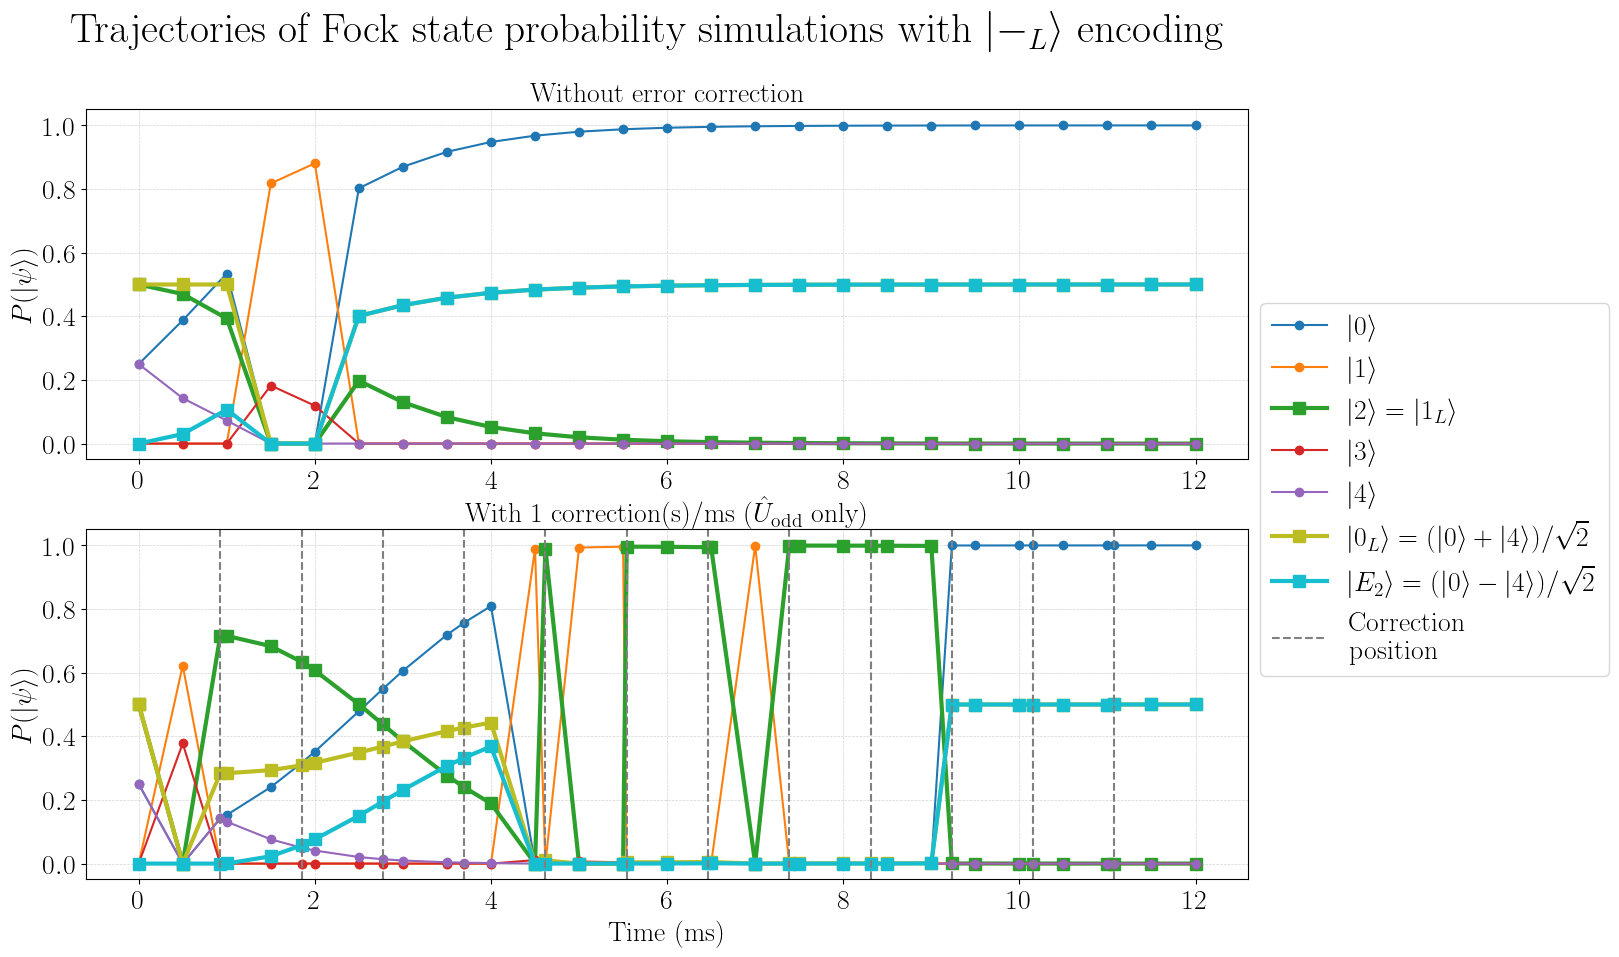

In [118]:
### Adjust these parameters ###
run = [(16, 0), (1, 2), (0, 3), (2, 1)] # Choose single shot to graph. Tuples are formatted as (noise_only_shot, correction_shot).
## 

# For formatting graphs
encoding=['logi0', 'logi1', 'logi_xplus', 'logi_xminus']
encoding_format = {'logi0': r'$0_L$', 'logi1': r'$1_L$', 'logi_xplus': r'$+_L$', 'logi_xminus':r'$-_L$', 'logi_yplus':r'$+i_L$', 'logi_yminus': r'$-i_L$'}

# Colors for plotting
colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Plot photon probability for all initial encodings
for index, value in enumerate(encoding):
    _, _, noise_only_prob_tuple, noise_only_snapshot_timings, _ = noise_only_simulation_list[index]
    _, _, correction_prob_tuple, correction_snapshot_timings, corr_position_times = correction_simulation_list[index]

    # Fock state probability visualization, single shot
    noise_only_prob, noise_only_prob_logical  = noise_only_prob_tuple
    correction_prob, correction_prob_logical = correction_prob_tuple

    # Runs to plot
    run_noise, run_corr = run[index]
    
    noise_only_fock_prob = [i[run_noise] for i in noise_only_prob]
    correction_fock_prob = [i[run_corr] for i in correction_prob]

    noise_only_fock_prob_logical = [i[run_noise] for i in noise_only_prob_logical]
    correction_fock_prob_logical = [i[run_corr] for i in correction_prob_logical]

    logical_label = [r'$\lvert 0_L \rangle = (\lvert 0 \rangle + \lvert 4 \rangle)/\sqrt{2}$', 
                     r'$\lvert E_2 \rangle = (\lvert 0 \rangle - \lvert 4 \rangle)/\sqrt{2}$', 
                     r'$\lvert 1_L \rangle$']

    # Fock state probability visualization, average
    # noise_only_fock_prob = [np.mean(i, axis=0) for i in noise_only_prob]
    # noise_only_fock_prob_error = [np.std(i, axis=0)/np.sqrt(shots) for i in noise_only_prob]
    # correction_fock_prob = [np.mean(i, axis=0) for i in correction_prob]
    # correction_fock_prob_error = [np.std(i, axis=0)/np.sqrt(shots) for i in correction_prob]

    # Ignore trajectories of Fock states with prob below a certain value.
    prob_truncation = 0.005

    # Plot both graph in single image
    plt.figure(figsize=(15,10))
    plt.suptitle('Trajectories of Fock state probability simulations with ' + r'$\lvert$' + str(encoding_format.get(value)) + r'$\rangle$' + ' encoding', size=30)
    # plt.suptitle('No correction and ' + str(num_corr) + ' correction simulation, with ' +r'$\lvert$' + str(encoding_format.get(encoding)) + r'$\rangle$' + ' encoding', size=20)

    ## 1a. Noise only circuit plot (photon number)
    plt.subplot(2, 1, 1)
    plt.subplot(2, 1, 1).xaxis.set_tick_params(labelsize=20)
    plt.subplot(2, 1, 1).yaxis.set_tick_params(labelsize=20)
    n = len(noise_only_fock_prob[0])
    # n,  = noise_only_avg_prob[0].shape
    for index in range(n):
        trajectory = [value[index] for value in noise_only_fock_prob]
        # uncert = [value[index] for value in noise_only_fock_prob_error]
        if all(i <= prob_truncation for i in trajectory):
            continue
        
        state = index
        # Rename state |2> = |1_L>
        if index == 2:
            state=logical_label[2]
            plt.plot(noise_only_snapshot_timings, trajectory, marker='s', label=r'$\lvert 2 \rangle =$ ' + str(state), color=colors[index], markersize = 8, linewidth = 3)
        else:
            plt.plot(noise_only_snapshot_timings, trajectory, marker='o', label=r'$\lvert$' + str(state) + r'$\rangle$', color=colors[index])

    ## 1b. Noise only circuit plot (logical state)
    m = len(noise_only_fock_prob_logical[0])
    for index in range(m):
        trajectory = [value[index] for value in noise_only_fock_prob_logical]
        if all(i <= prob_truncation for i in trajectory):
            continue
        plt.plot(noise_only_snapshot_timings, trajectory, marker='s', label=str(logical_label[index]), color=colors[index+8], markersize = 8, linewidth = 3)

    # Subplot 1 formatting
    #plt.ylabel("Probability of measuring Fock state, averaged over over {} shots".format(shots))
    plt.ylabel(r'$P(\lvert \psi \rangle$)', size=20)
    plt.title(r"Without error correction", size=20)
    plt.grid(color = 'lightgrey', linestyle = 'dashed', linewidth = 0.5)

    ## 2a. Correction circuit plot (photon number)
    plt.subplot(2, 1, 2, sharex = plt.subplot(2, 1, 1))
    plt.subplot(2, 1, 2).xaxis.set_tick_params(labelsize=20)
    plt.subplot(2, 1, 2).yaxis.set_tick_params(labelsize=20)
    n = len(correction_fock_prob[0])
    # n,  = correction_avg_prob[0].shape
    for index in range(n):
        trajectory = [value[index] for value in correction_fock_prob]
        # print(round(np.max(trajectory),4), round(np.median(trajectory),4), round(np.ptp(trajectory),4), index) ### debug
        # uncert = [value[index] for value in correction_fock_prob_error]
        if all(i <= prob_truncation for i in trajectory):
            continue
        state = index
        # Rename state |2> = |1_L>
        if index == 2:
            state=logical_label[2]
            plt.plot(correction_snapshot_timings, trajectory, marker='s', label=r'$\lvert 2 \rangle =$ ' + str(state), color=colors[index], markersize = 8, linewidth = 3)
        else:
            plt.plot(correction_snapshot_timings, trajectory, marker='o', label=r'$\lvert$' + str(state) + r'$\rangle$', color=colors[index])

    ## 1b. Correction circuit plot (logical state)
    m = len(correction_fock_prob_logical[0])
    for index in range(m):
        trajectory = [value[index] for value in correction_fock_prob_logical]
        if all(i <= prob_truncation for i in trajectory):
            continue
        plt.plot(correction_snapshot_timings, trajectory, marker='s', label=str(logical_label[index]), color=colors[index+8], markersize = 8, linewidth = 3)

    # Plot correction positions
    x, y = correction_positions(corr_position_times, correction_fock_prob, correction_snapshot_timings)
    label = 'Correction \n position'
    for i in x:
        plt.axvline(x=i, color='grey', label=label, linestyle="--")
        label = ''

    # Subplot 2 formatting
    plt.xlabel("Time (ms)", size=20)
    #plt.ylabel("Probability of measuring Fock state, averaged over {} shots".format(shots))
    plt.ylabel(r'$P(\lvert \psi \rangle$)', size=20)
    plt.title("With " + str(num_corr) + r" correction(s)/ms ($\hat{U}_{\text{odd}}$ only)", size=20)
    plt.grid(color = 'lightgrey', linestyle = 'dashed', linewidth = 0.5)

    # Remove duplicate labels
    leg1 = {l:h for h,l in zip(*plt.subplot(2, 1, 1).get_legend_handles_labels())}
    leg2 = {l:h for h,l in zip(*plt.subplot(2, 1, 2).get_legend_handles_labels())}

    plt.figlegend(*[*zip(*{**leg1, **leg2}.items())][::-1], bbox_to_anchor=(1.15, 0.5), loc = 'right', fontsize=20)
    plt.show()

From the charts above, we see that the no correction and with correction runs for $\ket{0_L}$ have no discernable difference. This is the result of disabling $\hat{U}_{\text{even}}$ so that only $\hat{U}_{\text{odd}}$ is applied during the recovery procedure. 

Fortunately, the no correction and with correction runs for $\ket{1_L}$ have clear differences. As evident from the charts above, the no correction shot for $\ket{1_L}$ starts out with 100% probability of measuring $\ket{1_L}$, and quickly decays from $\ket{1_L}=\ket{2} -> \ket{1} -> \ket{0}$. On the other hand, the correction shot oscillates between $\ket{2}$ and $\ket{1}$ (due to the effect of applying $\hat{U}_{\text{odd}}$ during the recovery operation) before eventually decaying to $\ket{0}$ at a much later time.

The result seen in the no correction and with correction runs for $\ket{+_L}$ and $\ket{-_L}$ contain a mixture of the above two effects.

### Simulation 2
For our second simulation, both $\hat{U}_{odd}$ and $\hat{U}_{even}$ are applied during the recovery operation. If the state is measured to have odd parity, $\hat{U}_{odd}$ is applied. And if the state has even parity, $\hat{U}_{even}$ is applied.

In [141]:
# Run simulation with and without correction. Enable u_even
noise_only_pauli_tuple, noise_only_fid, noise_only_prob, noise_only_snapshot_timings, _ = error_correction_experiment(encoding, 0, shots, additional_snaps, noise_only_circ_time)
correction_pauli_tuple, correction_fid, correction_prob, correction_snapshot_timings, corr_position_times = error_correction_experiment(encoding, num_corr, shots, additional_snaps, correction_circ_time)

a) State Fidelity

As before, the trajectory of the state fidelity is fitted with $f(t) = e^{-t/\tau}$, where $\tau$ is a constant representing the lifetime of the logical qubit. Red boxes are used to mark out the specific locations where the recovery procedure was done.

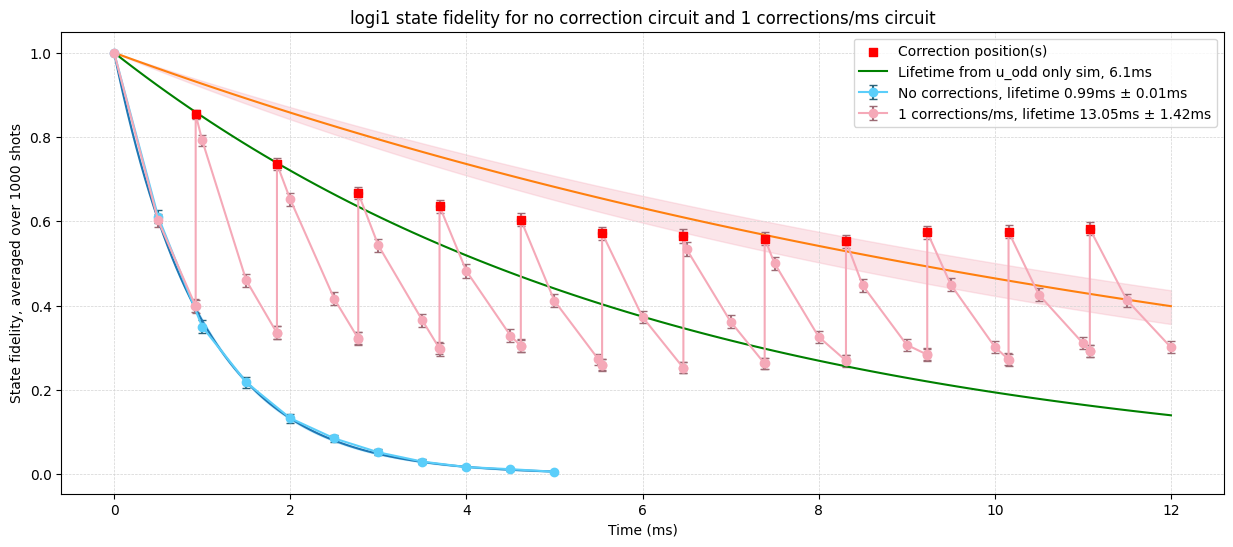

In [142]:
## Fidelity visualisation
noise_only_avg_fid = [round(np.average(cycle), 4) for cycle in noise_only_fid]
noise_only_avg_fid_error = [round(np.std(cycle)/np.sqrt(shots), 4) for cycle in noise_only_fid]

correction_avg_fid = [round(np.average(cycle), 4) for cycle in correction_fid]
correction_avg_fid_error = [round(np.std(cycle)/np.sqrt(shots), 4) for cycle in correction_fid]

# Find correction positions
x, y = correction_positions(corr_position_times, correction_avg_fid, correction_snapshot_timings)

# Fit fidelity data using an exponential decay function
noise_only_lifetime, noise_lifetime_uncertainty = curve_fitter(noise_only_snapshot_timings, noise_only_avg_fid)
correction_lifetime, correction_lifetime_uncertainty = curve_fitter(x, y)

# Plot fidelity data w/ uncertainty
plt.figure(figsize=(15,6))
plt.errorbar(noise_only_snapshot_timings, noise_only_avg_fid, yerr=noise_only_avg_fid_error,
         label="No corrections, lifetime {}ms ± {}ms".format(noise_only_lifetime, noise_lifetime_uncertainty), marker='o', color='#5BCEFA', capsize=3, ecolor='#2a6278')
plt.errorbar(correction_snapshot_timings, correction_avg_fid, yerr=correction_avg_fid_error,
         label="{} corrections/ms, lifetime {}ms ± {}ms".format(num_corr, correction_lifetime, correction_lifetime_uncertainty), marker='o', color='#F5A9B8', capsize=3, ecolor='#9c6b75')

# Plot curve fits w/ uncertainty
noise_curve_timing = np.linspace(0, noise_only_circ_time, 100)
plt.plot(noise_curve_timing, np.exp(-noise_curve_timing/noise_only_lifetime))
plt.fill_between(noise_curve_timing, np.exp(-noise_curve_timing/(noise_only_lifetime + noise_lifetime_uncertainty)), 
                 np.exp(-noise_curve_timing/(noise_only_lifetime - noise_lifetime_uncertainty)), color='#5BCEFA', alpha=0.3)

corr_curve_timing = np.linspace(0, correction_circ_time, 100)
plt.plot(corr_curve_timing, np.exp(-corr_curve_timing/correction_lifetime))
plt.fill_between(corr_curve_timing, np.exp(-corr_curve_timing/(correction_lifetime + correction_lifetime_uncertainty)), 
                 np.exp(-corr_curve_timing/(correction_lifetime - correction_lifetime_uncertainty)), color='#F5A9B8', alpha=0.3)

# Plot correction positions
plt.scatter(x, y, marker = 's', label = "Correction position(s)", color = 'red', zorder=3)

# This is perfect piece
perf = np.linspace(0, correction_circ_time, 100)
plt.plot(perf, np.exp(-perf/correction_lifetime_perf), color='green', label = "Lifetime from u_odd only sim, {}ms".format(correction_lifetime_perf))

plt.xlabel("Time (ms)")
plt.ylabel("State fidelity, averaged over {} shots".format(shots))
plt.title("{} state fidelity for no correction circuit and {} corrections/ms circuit".format(encoding, num_corr))
plt.grid(color = 'lightgrey', linestyle = 'dashed', linewidth = 0.5)
plt.legend(loc='upper right')
plt.show()

Here we see that the state fidelity of the correction circuit does not decay exponentially. For comparison, the behavior observed previously is plotted in green. This change is behavior is due to the inclusion of the $\hat{U}_{even}$ operator. In the second simulation, after the qumode falls to the $\ket{0}$ state, the the correction circuit will measure even parity and apply $\hat{U}_{even}$. Since $\hat{U}_{even}$ maps $\ket{0}$ to a superposition of $\alpha \ket{0} + \beta \ket{4}$, where $\beta < \alpha$, there will be some non-zero probability of the state encountering a two-photon loss event and flipping from $\alpha \ket{0} + \beta \ket{4}$ to $\ket{2}=\ket{1_L}$.

Hence on average, we see that the fidelity measurement plateaus as a result of shots which continually oscillate between $\ket{1_L} and \ket{0}$.

b) Photon probability
To better visualize this oscillating behavior, we can look at the photon probability of a single shot. 

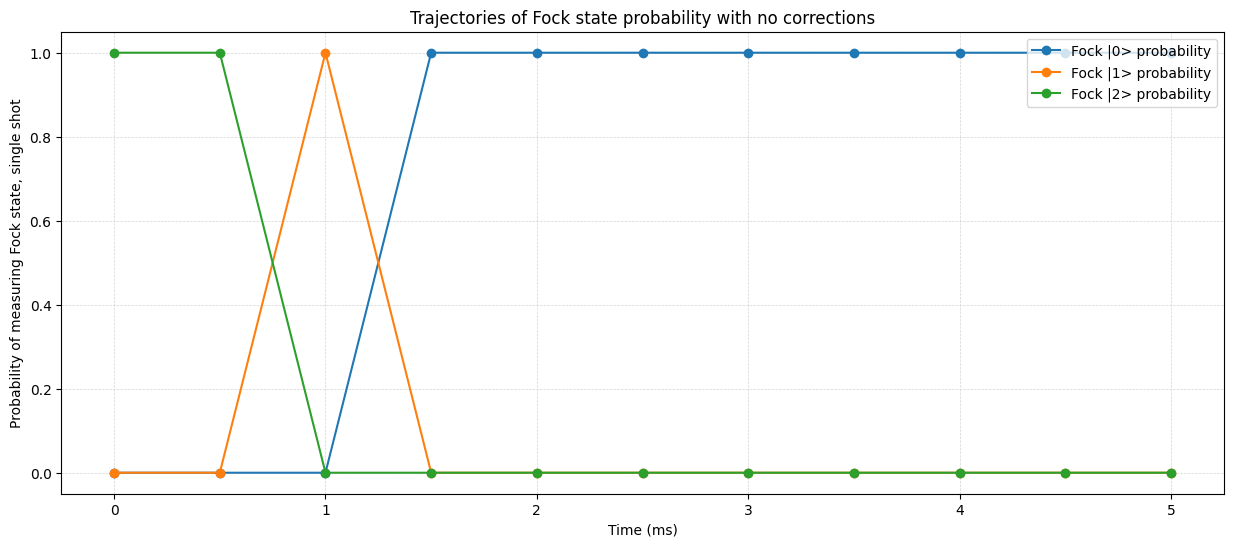

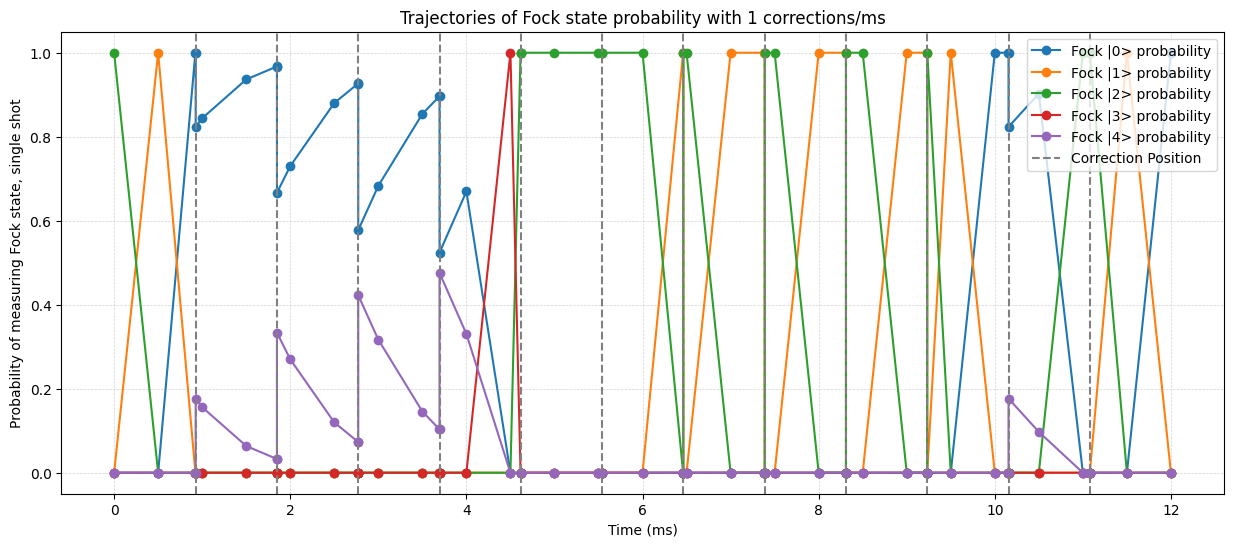

In [143]:
# Fock state probability visualization, single shot
noise_only_fock_prob = [i[0] for i in noise_only_prob]
correction_fock_prob = [i[0] for i in correction_prob]

# Fock state probability visualization, average
# noise_only_fock_prob = [np.mean(i, axis=0) for i in noise_only_prob]
# noise_only_fock_prob_error = [np.std(i, axis=0)/np.sqrt(shots) for i in noise_only_prob]
# correction_fock_prob = [np.mean(i, axis=0) for i in correction_prob]
# correction_fock_prob_error = [np.std(i, axis=0)/np.sqrt(shots) for i in correction_prob]

# Ignore trajectories of Fock states with prob below a certain value.
prob_truncation = 0.005

# Plot Fock state distribution for noise only circuit
plt.figure(figsize=(15,6))
n = len(noise_only_fock_prob[0])
# n,  = noise_only_avg_prob[0].shape
for index in range(n):
    trajectory = [value[index] for value in noise_only_fock_prob]
    # uncert = [value[index] for value in noise_only_fock_prob_error]
    if all(i == 0 for i in trajectory):
        continue
    # plt.errorbar(noise_only_snapshot_timings, trajectory, yerr=uncert, marker='o', label="Fock |{}> probability".format(index), capsize=3, ecolor='grey')
    plt.plot(noise_only_snapshot_timings, trajectory, marker='o', label="Fock |{}> probability".format(index))
    
plt.xlabel("Time (ms)")
#plt.ylabel("Probability of measuring Fock state, averaged over over {} shots".format(shots))
plt.ylabel("Probability of measuring Fock state, single shot")
plt.title("Trajectories of Fock state probability with no corrections")
plt.legend(loc='upper right')
plt.grid(color = 'lightgrey', linestyle = 'dashed', linewidth = 0.5)
plt.show()

# Plot Fock state distribution for correction circuit
plt.figure(figsize=(15,6))
n = len(correction_fock_prob[0])
# n,  = correction_avg_prob[0].shape
for index in range(n):
    trajectory = [value[index] for value in correction_fock_prob]
    # print(round(np.max(trajectory),4), round(np.median(trajectory),4), round(np.ptp(trajectory),4), index) ### debug
    # uncert = [value[index] for value in correction_fock_prob_error]
    if all(i <= prob_truncation for i in trajectory):
        continue
    # plt.errorbar(correction_snapshot_timings, trajectory, yerr=uncert, marker='o', label="Fock |{}> probability".format(index), capsize=3, ecolor='grey')
    plt.plot(correction_snapshot_timings, trajectory, marker='o', label="Fock |{}> probability".format(index))
    
# Plot correction positions
x, y = correction_positions(corr_position_times, correction_fock_prob, correction_snapshot_timings)
label = 'Correction Position'
for i in x:
    plt.axvline(x=i, color='grey', label=label, linestyle="--")
    label = ''

plt.xlabel("Time (ms)")
#plt.ylabel("Probability of measuring Fock state, averaged over {} shots".format(shots))
plt.ylabel("Probability of measuring Fock state, single shot")
plt.title("Trajectories of Fock state probability with {} corrections/ms".format(num_corr))
plt.legend(loc='upper right')
plt.grid(color = 'lightgrey', linestyle = 'dashed', linewidth = 0.5)
plt.show()

As seen above, although the correction circuit simulation begun in the $|2>$ state, it oscillates between $|2>$ and the $\alpha \ket{0} + \beta \ket{4}$ superposition state. This is due to the inclusion of the $\hat{U}_{even}$ operator, which will continuously act on the state whenever the qumode is in an even state. The operator provides a pathway for the state to return to $|2>$ even after the state has decayed to $\ket{0}$. 

This means that fidelity and photon probability are no longer adequate for characterizing the decay of logical information within the qumode. Hence, we now introduce the Pauli expectation value as a way to calculate logical qubit lifetime.

c) Pauli expectation value

The Pauli expectation value is calculated with respect to the logical Pauli state that was encoded at the start of the simulation. This simulation allows for the following six states:

Logical Z Pauli states: 
\begin{align*}
\ket{0_L} &= \frac{1}{\sqrt{2}} [\ket{0} + \ket{4}] \\
\ket{1_L} &= \ket{2}
\end{align*}

Logical X Pauli states:
\begin{align*}
\ket{+_L} &= \frac{1}{\sqrt{2}} [\ket{0_L} + \ket{1_L}] \\
\ket{-_L} &= \frac{1}{\sqrt{2}} [\ket{0_L} - \ket{1_L}] 
\end{align*}

Logical Y Pauli states:
\begin{align*}
\ket{+i_L} &= \frac{1}{\sqrt{2}} [\ket{0_L} + i\ket{1_L}] \\
\ket{-i_L} &= \frac{1}{\sqrt{2}} [\ket{0_L} - i\ket{1_L}]
\end{align*}

For ease of computation, we first decode the logical Pauli state using the following projector:
\begin{align*}
P_{decode} = \ket{0}_{qubit} \bra{0_L}_{qumode} + \ket{1}_{qubit} \bra{1_L}_{qumode}
\end{align*}
The projector $P_{decode}$ decodes the logical Pauli state by extracting the logical information stored within the qumode. As projections are not unitary, we need to renormalize the extracted state before calculating the Pauli expectation value. The sequence of steps is as follows:

1. Apply $P_{decode} \ket{\psi_L} = \ket{\psi}$
2. Renormalize $\frac{\ket{\psi}}{\braket{\psi |\psi}} = \ket{\tilde{\psi}}$
3. Compute Pauli expectation with respective Pauli operator $\braket{\tilde{\psi} | O_{Pauli} |\tilde{\psi}}, O_{Pauli} \in \{X, Y, Z\}$.

The states $\ket{0_L}, \ket{+_L}$, and $\ket{+i_L}$ have a Pauli expectation of $+1$, while states $\ket{1_L}, \ket{-_L}$, and $\ket{-i_L}$ have a Pauli expectation of $-1$.

The trajectory of the Pauli expectation value for $\ket{-_L}, \ket{+i_L}$, and $\ket{0_L}$ will be plotted to determine the lifetime of the qumode. For the sake of visibility, two corrections/ms will be applied.

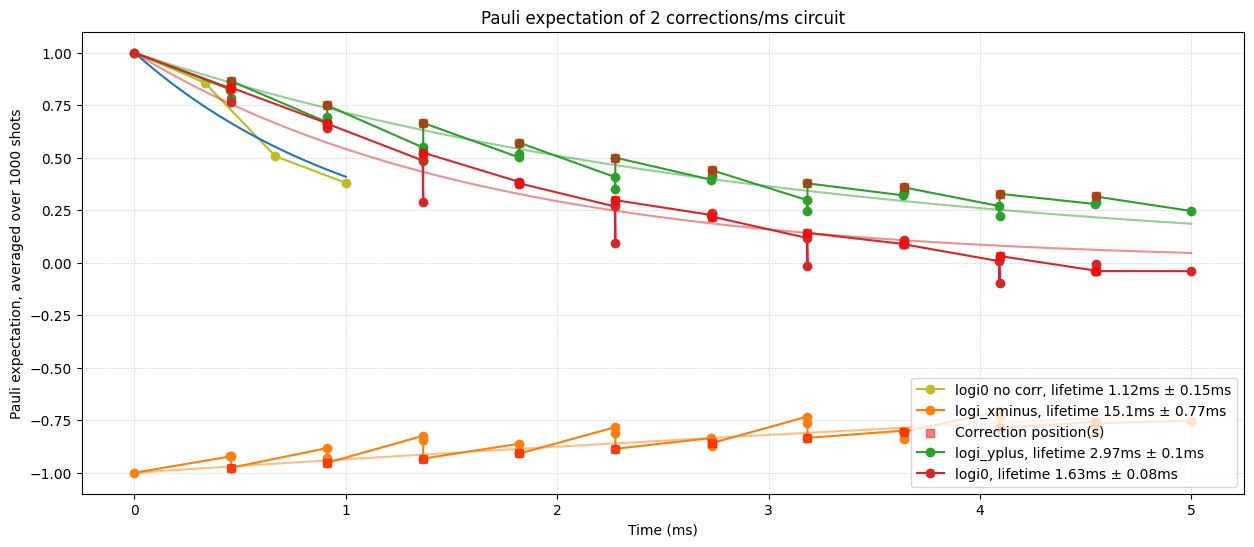

In [22]:
encoding = ['logi_xminus', 'logi_yplus', 'logi0']
sign = [-1, 1, 1]
colors= ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
correction_circ_time = 5
noise_only_circ_time = 1
num_corr = 2

# Plot no corr run 
plt.figure(figsize=(15,6))
(noise_only_pauli_expectation, _), _, _, noise_only_snapshot_timings, _ = error_correction_experiment('logi0', 0, shots, 3, noise_only_circ_time)
noise_only_expectation_avg = [np.round(np.average(cycle), 4) for cycle in noise_only_pauli_expectation]
noise_only_lifetime, noise_lifetime_uncertainty = curve_fitter(noise_only_snapshot_timings, noise_only_expectation_avg)
plt.plot(noise_only_snapshot_timings, noise_only_expectation_avg,
            label="{} no corr, lifetime {}ms ± {}ms".format('logi0', noise_only_lifetime, noise_lifetime_uncertainty), marker='o', color=colors[7])
noise_curve_timing = np.linspace(0, noise_only_circ_time, 100)
plt.plot(noise_curve_timing, np.exp(-noise_curve_timing/noise_only_lifetime))

label = "Correction position(s)"
# Plot corr runs
for index, i in enumerate(encoding):
    correction_pauli_tuple, _, _, correction_snapshot_timings, corr_position_times = error_correction_experiment(i, num_corr, shots, 0, correction_circ_time)

    # Pauli operator decay visualization
    correction_pauli_expectation, _ = correction_pauli_tuple

    # Compute average expectation and prob across all shots
    correction_expectation_avg = [np.round(np.average(cycle), 4) for cycle in correction_pauli_expectation]

    # Expectation plots
    correction_lifetime, correction_lifetime_uncertainty = curve_fitter(correction_snapshot_timings, correction_expectation_avg, sign[index])

    # Plot expectation data
    plt.plot(correction_snapshot_timings, correction_expectation_avg,
            label="{}, lifetime {}ms ± {}ms".format(i, correction_lifetime, correction_lifetime_uncertainty), marker='o', color=colors[index])

    # Plot expectation data curve fits
    corr_curve_timing = np.linspace(0, correction_circ_time, 100)
    plt.plot(corr_curve_timing, sign[index] * np.exp(-corr_curve_timing/correction_lifetime), alpha=0.5, color=colors[index])
    
    # Plot value after recovery
    x, y = correction_positions(corr_position_times, correction_expectation_avg, correction_snapshot_timings)
    plt.scatter(x, y, marker = 's', label = label, color = 'red', zorder=3, alpha = 0.5)
    label = ''

plt.xlabel("Time (ms)")
plt.ylabel("Pauli expectation, averaged over {} shots".format(shots))
plt.title("Pauli expectation of {} corrections/ms circuit".format(num_corr))
plt.grid(color = 'lightgrey', linestyle = 'dashed', linewidth = 0.5)
plt.legend(loc='lower right')
plt.show()

As evident in the chart above, there is an increase in the lifetime of the logical Pauli state when corrections are applied. From all of the measurements we've seen thus far, it is apt to conclude that the error correction circuit does increase the lifetime of the logical state. 

## References
[1] Girvin, Steven M. 2021. "Introduction to Quantum Error Correction and Fault Tolerance." arXiv. https://doi.org/10.48550/ARXIV.2111.08894.

[2] Albert, Victor V., and Philippe Faist. 2022. "Binomial Code." The Error Correction Zoo. https://errorcorrectionzoo.org/c/binomial.

## Appendix with Further Charts

All six logical Pauli states, plotted on separate charts.

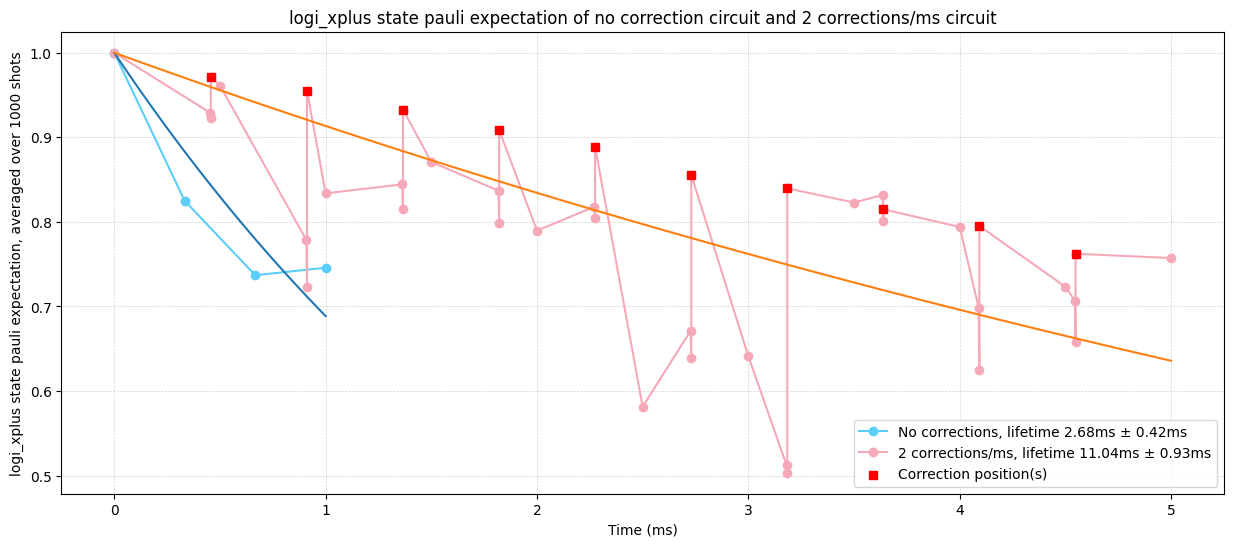

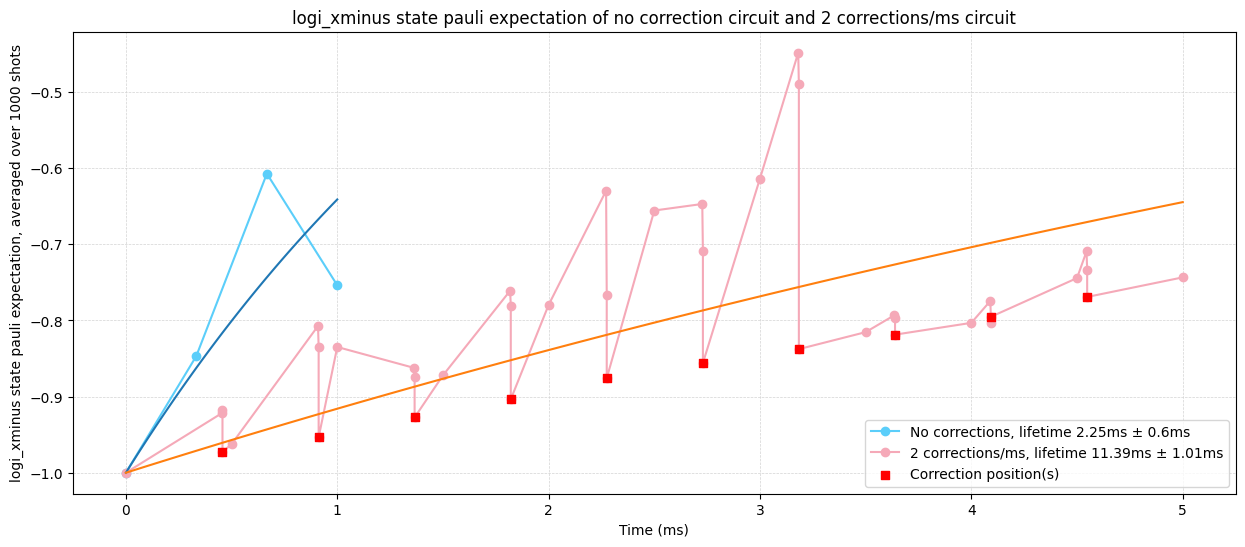

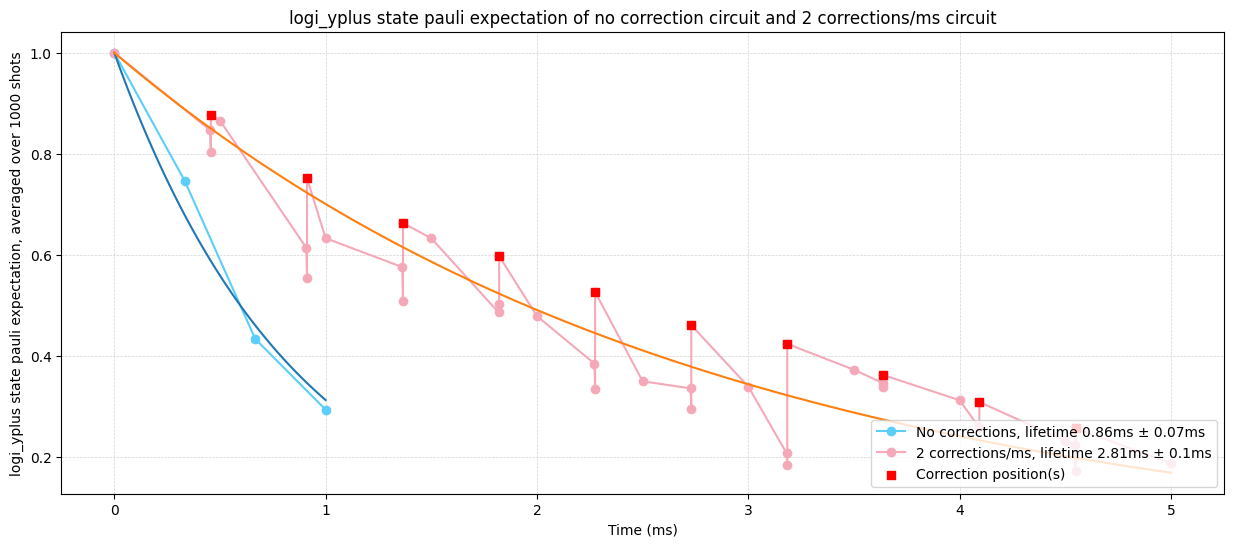

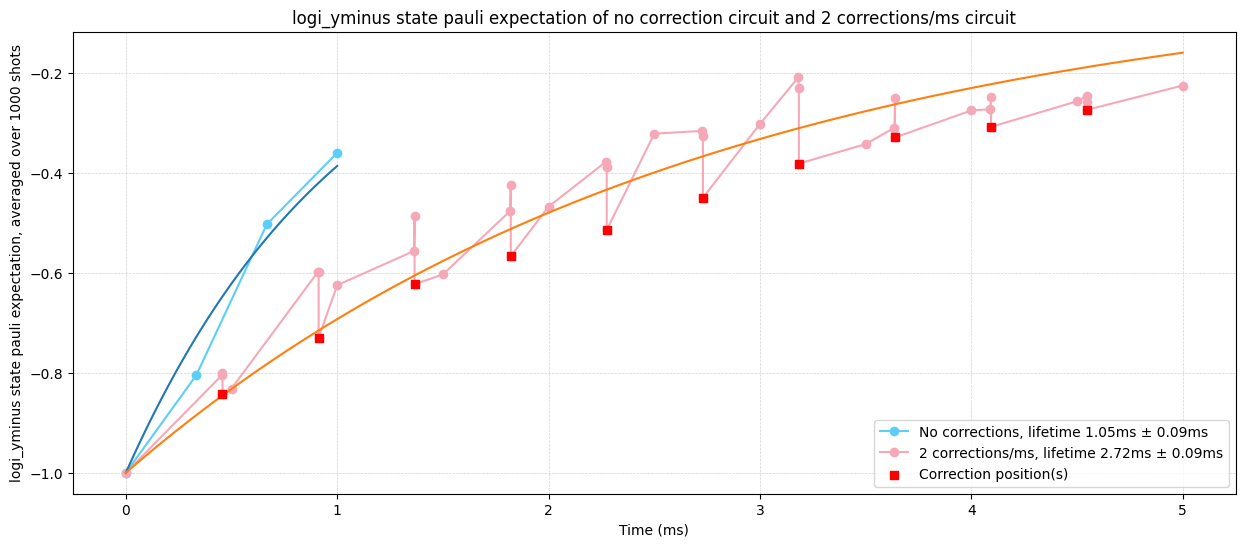

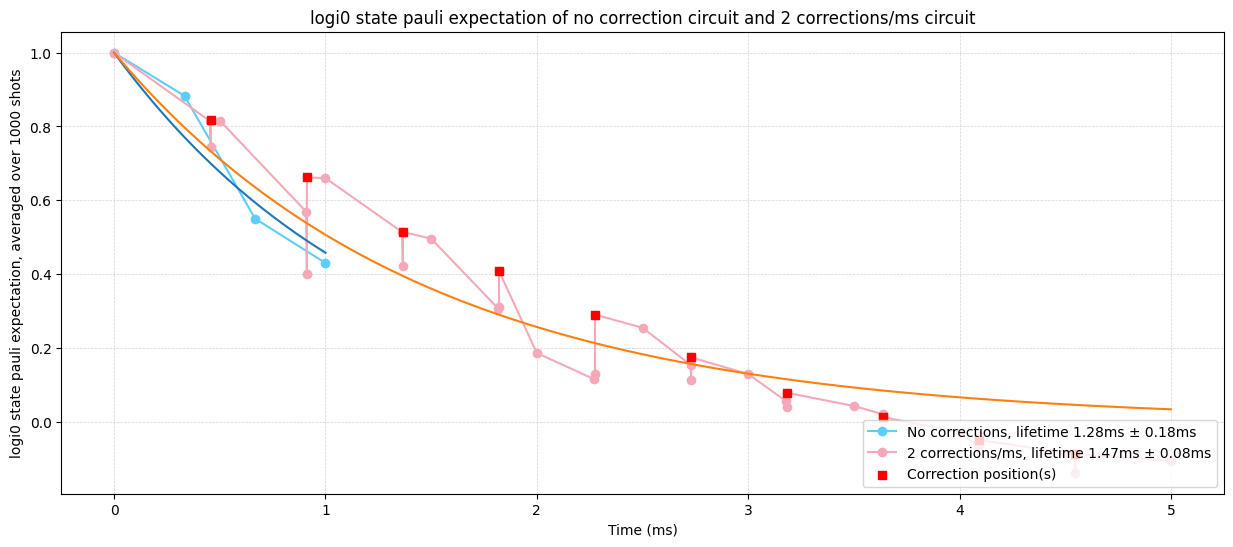

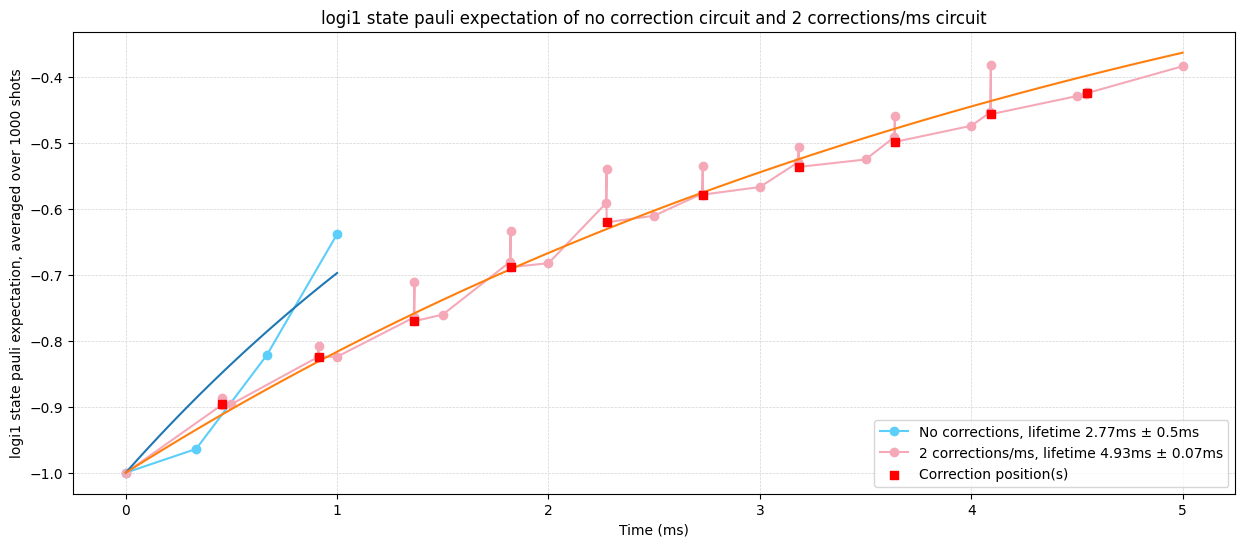

In [23]:
## All six states on separate charts
encoding = ['logi_xplus', 'logi_xminus', 'logi_yplus', 'logi_yminus', 'logi0', 'logi1']
sign = [1, -1, 1, -1, 1, -1]
for index, i in enumerate(encoding):
    noise_only_pauli_tuple, noise_only_fid, noise_only_prob, noise_only_snapshot_timings, _ = error_correction_experiment(i, 0, shots, 3, noise_only_circ_time)
    correction_pauli_tuple, correction_fid, correction_prob, correction_snapshot_timings, corr_position_times = error_correction_experiment(i, num_corr, shots, additional_snaps, correction_circ_time)

    ## Pauli operator decay visualization
    noise_only_pauli_expectation, noise_only_pauli_prob = noise_only_pauli_tuple #[[matrix.real for matrix in cycle] for cycle in noise_only_pauli]
    correction_pauli_expectation, correction_pauli_prob = correction_pauli_tuple

    # Compute average expectation and prob across all shots
    noise_only_expectation_avg = [np.round(np.average(cycle), 4) for cycle in noise_only_pauli_expectation]
    correction_expectation_avg = [np.round(np.average(cycle), 4) for cycle in correction_pauli_expectation]

    noise_only_pauli_prob_avg =  [np.round(np.average(cycle), 4) for cycle in noise_only_pauli_prob]
    correction_pauli_prob_avg = [np.round(np.average(cycle), 4) for cycle in correction_pauli_prob]

    ## Expectation plots
    # Fit expectation data using an exponential decay function
    noise_only_lifetime, noise_lifetime_uncertainty = curve_fitter(noise_only_snapshot_timings, noise_only_expectation_avg, sign[index])
    correction_lifetime, correction_lifetime_uncertainty = curve_fitter(correction_snapshot_timings, correction_expectation_avg, sign[index])

    # Plot expectation data
    plt.figure(figsize=(15,6))
    plt.plot(noise_only_snapshot_timings, noise_only_expectation_avg,
            label="No corrections, lifetime {}ms ± {}ms".format(noise_only_lifetime, noise_lifetime_uncertainty), marker='o', color='#5BCEFA')
    plt.plot(correction_snapshot_timings, correction_expectation_avg,
            label="{} corrections/ms, lifetime {}ms ± {}ms".format(num_corr, correction_lifetime, correction_lifetime_uncertainty), marker='o', color='#F5A9B8')

    # Plot expectation data curve fits
    noise_curve_timing = np.linspace(0, noise_only_circ_time, 100)
    plt.plot(noise_curve_timing, sign[index] * np.exp(-noise_curve_timing/noise_only_lifetime))
    corr_curve_timing = np.linspace(0, correction_circ_time, 100)
    plt.plot(corr_curve_timing, sign[index] * np.exp(-corr_curve_timing/correction_lifetime))

    # Plot correction positions
    x, y = correction_positions(corr_position_times, correction_expectation_avg, correction_snapshot_timings)
    plt.scatter(x, y, marker = 's', label = "Correction position(s)", color = 'red', zorder=3)

    plt.xlabel("Time (ms)")
    plt.ylabel("{} state pauli expectation, averaged over {} shots".format(i, shots))
    plt.title("{} state pauli expectation of no correction circuit and {} corrections/ms circuit".format(i, num_corr))
    plt.grid(color = 'lightgrey', linestyle = 'dashed', linewidth = 0.5)
    plt.legend(loc='lower right')
    plt.show()

#     ## Probability of projection plots
#     plt.figure(figsize=(15,6))
#     plt.plot(noise_only_snapshot_timings, noise_only_pauli_prob_avg,
#             label="No corrections, lifetime {}ms ± {}ms".format(noise_only_lifetime, noise_lifetime_uncertainty), marker='o', color='#5BCEFA')
#     plt.plot(correction_snapshot_timings, correction_pauli_prob_avg,
#             label="{} corrections/ms, lifetime {}ms ± {}ms".format(num_corr, correction_lifetime, correction_lifetime_uncertainty), marker='o', color='#F5A9B8')

#     x, y = correction_positions(corr_position_times, correction_pauli_prob_avg, correction_snapshot_timings)
#     plt.scatter(x, y, marker = 's', label = "Correction position(s)", color = 'red', zorder=3)

#     plt.xlabel("Time (ms)")
#     plt.ylabel("{} state pauli probability, averaged over {} shots".format(i, shots))
#     plt.title("{} state pauli probability of no correction circuit and {} corrections/ms circuit".format(i, num_corr))
#     plt.grid(color = 'lightgrey', linestyle = 'dashed', linewidth = 0.5)
#     plt.legend(loc='lower right')
#     plt.show()

Distribution of fidelity values for every snapshot:

In [ ]:
## Fidelity distribution plotting
entries = ceil(np.sqrt(len(noise_only_snapshot_timings)))

fig = plt.figure(figsize=(15,6), layout='constrained')
fig.suptitle("Fidelity distribution across various points in noise only circuit")

#fig.add_axes(sharex=True)
#plt.subplots(nrows=entries, ncols=entries, figsize=(15, 6), sharex=True, sharey=True)
for index, timing in enumerate(noise_only_snapshot_timings):
    plt.subplot(entries, entries, (index + 1), title="Distribution at {}ms".format(timing), ylabel="counts", xlabel ="Fidelity", ylim=(0, 1000), xlim=(-0.1, 1.1))
    counts, bins = np.histogram(noise_only_fid[index])
    plt.stairs(counts, bins)

# plt.supxlabel("Fidelity")
# plt.supylabel("Count")
plt.show()


entries = ceil(np.sqrt(len(correction_snapshot_timings)))

fig = plt.figure(figsize=(15,6), layout='constrained')
fig.suptitle("Fidelity distribution across various points in 2corr/ms circuit")

#fig.add_axes(sharex=True)
#plt.subplots(nrows=entries, ncols=entries, figsize=(15, 6), sharex=True, sharey=True)
for index, timing in enumerate(correction_snapshot_timings):
    if any(timing * 1000 == corr_position for corr_position in corr_position_times):
        plt.subplot(entries, entries, (index + 1), title="Distribution at {}ms".format(timing), ylabel="counts", xlabel ="Fidelity", facecolor='lightgrey', ylim=(0, 1000), xlim=(-0.1, 1.1))
    else:
        plt.subplot(entries, entries, (index + 1), title="Distribution at {}ms".format(timing), ylabel="counts", xlabel ="Fidelity", ylim=(0, 1000), xlim=(-0.1, 1.1))
    counts, bins = np.histogram(correction_fid[index])
    plt.stairs(counts, bins)

# plt.supxlabel("Fidelity")
# plt.supylabel("Count")
plt.show()